![puma logo](https://github.com/nasa/puma/raw/main/doc/source/puma_logo.png)
# Welcome to the PuMA tutorial

The objective of this notebook is to familiarize new users with the main datastructures that stand at the basis of the PuMA project, and outline the functions to compute material properties (please refer to [this paper](https://www.sciencedirect.com/science/article/pii/S235271102100090X) for more details on the software).

# Installation setup and imports

If you are running this jupyter notebook locally on your machine, then you don't need to run any setup, granted that you installed PuMA using the installer.sh script. 

If you are running this notebook online on Google Colab and you only need to run the python tutorials (except for the one about Weaves), the following command is enough to setup the environment:

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install 'git+https://github.com/nasa/puma'
    !pip install -q piglet pyvirtualdisplay
    !apt-get -qq install xvfb

Finally, if you instead need to either run the C++ PuMA code or the Weaves TexGen tutorial on Colab, then you need to run the following cell, which will take about 10-15 mins:

In [2]:
import os
if 'google.colab' in str(get_ipython()):
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    !pip install -q piglet pyvirtualdisplay
    !apt-get -qq install xvfb
    !if [[ $(conda list puma) != *"puma"* ]]; then conda install -c conda-forge puma; fi
    os.environ['CONDA_PREFIX'] = "/usr/local/"  # necessary for C++ CMakeLists
    try:
        import pumapy as puma
    except:  # Colab needs to restart kernel the first time puma is installed
        import os; os.kill(os.getpid(), 9)  # intentionally crash kernel to force restart

# Python tutorials

In this section, we introduce how to use the pumapy python package. We start by importing the necessary packages:

In [3]:
import numpy as np
import pumapy as puma
import pyvista as pv
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import os
import sys
if 'google.colab' in str(get_ipython()):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(600, 400))
    display.start()  # necessary for pyvista interactive plots
    
else:  # NORMAL JUPYTER NOTEBOOK
    # for interactive slicer (only static allowed on Colab)
    %matplotlib widget

## Tutorial: Workspace Manipulations
In this tutorial we demonstrate how to create a workspace and perform basic operations on it, including cropping, rotation, thresholding.

A workspace is the datastructure at the basis of both PuMA and pumapy and it is basically a container for the material sample that is being analyzed. A workspace is made of little cubes, or voxels (i.e. 3D pixels), holding a value. This simple element definition (formally called Cartesian grid) allows for very fast operations. Inside a workspace object, two different arrays are defined: one called "matrix" and the other called "orientation". Both of these are nothing but a 3D Numpy array for the matrix (X,Y,Z dimensions of the domain) and a 4D Numpy array for the orientation (dimensions of X,Y,Z,3 for vectors throughout the domain). 

Next we show the different ways we have implemented to define a workspace class. You can check how to use the methods by running the following commands:

In [ ]:
help(puma.Workspace)  # all class methods

In [ ]:
help(puma.Workspace.rescale)  # specific class method

In [ ]:
# defines a workspace full of zeros of shape 10x11x12
ws = puma.Workspace.from_shape((10, 11, 12))
print(f"Shape of workspace: {ws.matrix.shape}")
print(f"Unique values in matrix: {ws.unique_values()}")

In [ ]:
# defines a workspace of shape 20x31x212, full of a custom value (in this case ones)
ws = puma.Workspace.from_shape_value((20, 31, 212), 1)
print(f"Shape of workspace: {ws.matrix.shape}")
print(f"Unique values in matrix: {ws.unique_values()}")

In [ ]:
# defines a workspace of shape 5x6x2, full of a custom value (in this case ones) for the matrix array
# and vectors for the orientation array
ws_with_orientation = puma.Workspace.from_shape_value_vector((5, 6, 2), 1, (0.4, 2, 5))
print(f"Matrix shape of workspace: {ws_with_orientation.matrix.shape}")
print(f"Orientation shape of workspace: {ws_with_orientation.orientation.shape}")
print("Display Workspace matrix")
ws_with_orientation.show_matrix()

In [ ]:
print("Display Workspace orientation")
ws_with_orientation.show_orientation()

In [ ]:
# we can also convert a Numpy array into a Workspace directly by running:
array = np.random.randint(5, size=(10, 10, 10))
ws = puma.Workspace.from_array(array)
print(f"Matrix shape of workspace: {ws.get_shape()}")

In [ ]:
# finally, we can create an empty workspace object and assign its matrix directly (not recommended):
ws = puma.Workspace()
ws.matrix = np.random.randint(5, size=(10, 10, 3))
print("Display Workspace")
ws.show_matrix()

In [ ]:
# N.B. the following commands are equivalent
print("Different ways to index the matrix array:")
print(ws[0, 0, 0])
print(ws.matrix[0, 0, 0])

It is important to keep the first three dimensions (X,Y,Z) of the matrix and orientation class variables the same. This is automatically enforced by using the class methods, but it is not when assigning them directly as in the last example. 

Let's now import a tomography image directly into a workspace (PuMA comes with some example files that can be imported using the path_to_example_file function as shown below): 

In [ ]:
ws_raw = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)
print(f"Shape of workspace: {ws_raw.matrix.shape}")

This specific tiff stack is 8 bit, so the grayscale values will range from 0 to 255. PuMA can also import 16bit images, which allow a much larger range from 0 to 65535 (i.e. 2^16).

The voxel length (in meters) of the workspace can either be set during import of a 3D tiff, or manually afterwards, as shown below: 

In [ ]:
ws_raw.voxel_length = 1.3e-6

We can visualize its slices by running the command below. By scrolling on top of the plot, you can slice through the material along the z axis. You can also use the left/right arrows on the keyboard to skip +/-10 slices or the up/down arrows to skip +/-100 slices (if this does not work automatically, try clicking on the plot first). In addition, on the bottom of the plot, the (x,y) coordinates are shown along with the corresponding grayscale value. 

Note that in Colab only static plots are allowed, so an index can be specified to indicate the slice to show.

In [ ]:
slices = puma.plot_slices(ws_raw, slice_direction='z', crange=None, cmap='gray', index=1)

Otherwise, we can also 3D render it as (see the visualization tutorial for more tips on this):

In [ ]:
puma.render_volume(ws_raw, notebook=True)

Next, we show how to manipulate the domain, e.g. crop, rescale, resize and rotate it. 

An approach to crop a domain is the following:

In [ ]:
ws_copy = ws_raw.copy()  # make a copy of the domain first
ws_copy.matrix = ws_copy[10:40, 35:, -20:]  # crop the domain by selecting ranges
print(f"Shape of original workspace: {ws_raw.get_shape()}")
print(f"Shape of cropped workspace: {ws_copy.get_shape()}")

However, it is important to not fall in the trap of referencing the same Numpy array. Here is an example of how you SHOULD NOT perform cropping:

In [ ]:
ws_bad = puma.Workspace()
ws_bad.matrix = ws_raw[10:40, 35:, -20:]  # WRONG: always make a copy first!
ws_bad[0, 0, 0] = np.random.randint(0, 255)  # otherwise, this line also changes ws_raw
print(ws_raw[10, 35, -20])
print(ws_bad[0, 0, 0])

As you can see from the output, both the original Workspace and the newly created one share the same Numpy array for the matrix class variable (the second one is only a section of it, also called a Numpy view). This way, when one is changed, the other one will be changed as well. It is important to make a copy of a domain if the original workspace needs to be kept.

Next, we show how we can rescale a domain by a factor or resize it to a specified size. 

In [ ]:
ws_copy = ws_raw.copy()
ws_copy.rescale(scale=0.5, segmented=False)

# Notice that now the axis have different limits
puma.compare_slices(ws_raw, ws_copy, index=50)

## Tutorial: import and export

In this tutorial we demonstrate how to input and output a computational domain in PuMA

### Explanation of data structures
First, we give a brief explanation of the PuMA data structures. For a more detailed description, refer to the tutorial on Workspace Manipulations.

Microstructures in PuMA are stored in a data structure called a "workspace". The workspace class includes all of the data about the material microstructure, including a 3D matrix of grayscale values, which can be either raw data from tomographic images, or segmented values. 

Note that in Colab only static plots are allowed, so an index can be specified to indicate the slice to show.

Examples of unsegmented and segmented workspaces are demonstrated below: 

In [ ]:
ws_unsegmented = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)
ws_segmented = ws_unsegmented.copy()
ws_segmented.binarize(90)

puma.compare_slices(ws_unsegmented, ws_segmented,'z', index=1)

The PuMA workspace class also contains other important information about the workspace. This includes the voxel length, which is the physical length (in meters) of each voxel of the image. Typical tomography data ranges from 1e-4 to 1e-7 meters in voxel length. If no value is provided to PuMA, the workspace class defaults to 1e-6 meters, i.e. one micron, as a voxel length. This value can either be set during input-output or it can be set directly for the workspace class. 

An example is shown below, where the voxel length of a workspace class is manually changed

In [ ]:
ws_unsegmented.voxel_length = 1.5e-6

The workspace class can also store the material orientation for each voxel in the domain. This data can either be imported, or can be computed using "compute_orientation_st" function, which applies the structure-tensor method to estimate the material orientation. 

### Workspace import and export
Now we will give examples of input and output for the workspace class. 

PuMA import and export uses three different file types: 3D tiff, vti, and binary (extension is .pumapy)

The 3D tiff images only include the 3D matrix data for the grayscale values. vti and binary, however, includes all data associated with the puma workspace class, including the matrix data, the orientation data (if used) and the voxel length. 

3D tiff images are often the exported data format for tomography imaging, so they are included in PuMA. If you have a tomographic image that uses a different file format, it is recommended to use an external image processing software (FIJI is recommended - https://imagej.net/software/fiji/) and convert the image to a 3D tiff before importing into pumapy. If tomographic reconstruction also needs to be performed, the python package called Tomopy (https://anaconda.org/conda-forge/tomopy) is recommended.

First, let's set where to export the output file:

In [ ]:
# Specify a path where to export file
export_path = 'out'  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

### Loading and exporting a .vti file

Now, we will import an example file from the example data inside the folder pumapy.data:

In [ ]:
ws_vtk = puma.import_vti(puma.path_to_example_file("fibers_with_orientation.vti"))

print("Voxel Length: ", ws_vtk.voxel_length)
print("Domain shape: ", ws_vtk.get_shape())

We can now visualize both the fibrous microstructure and the fiber orientation side by side (for more visualization tips, follow the visualization tutorial):

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Microstructure")
puma.render_contour(ws_vtk, (128, 255), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Fiber orientation")
puma.render_orientation(ws_vtk, notebook=True, add_to_plot=p, plot_directly=False)
p.show()

Finally, we will export it again to our specified directory:

In [ ]:
puma.export_vti(os.path.join(export_path, "fibers_with_orientation.vti"), ws_vtk)

And that's it for exporting to vti!  Let's repeat the same steps for .pumapy and 3D tiffs.

### Loading and exporting a .pumapy binary file

In [ ]:
ws_binary = puma.import_bin(puma.path_to_example_file("fibers_with_orientation.pumapy"))

print("Voxel Length: ", ws_binary.voxel_length)
print("Domain shape: ", ws_binary.get_shape())

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Microstructure")
puma.render_contour(ws_binary, (128, 255), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Fiber orientation")
puma.render_orientation(ws_binary, notebook=True, add_to_plot=p, plot_directly=False)
p.show()

In [ ]:
puma.export_bin(os.path.join(export_path, "fibers_with_orientation.vti"), ws_binary)

### Loading and exporting a .tif stack

In [ ]:
ws_tiff = puma.import_3Dtiff(puma.path_to_example_file("50_artfibers.tif"))

print("Voxel Length: ", ws_tiff.voxel_length)
print("Domain shape: ", ws_vtk.get_shape())

puma.render_contour(ws_tiff, (128,255), notebook=True)

puma.export_3Dtiff(os.path.join(export_path, "50_artfibers.tif"), ws_tiff)

As you can see, with the 3D tiff import, the voxel length of the original workspace and the orientation is not preserved. The voxel length can be set by either adding it as an option to the 3D tiff import call, or by setting it directly: 

In [ ]:
ws_tiff = puma.import_3Dtiff(puma.path_to_example_file("50_artfibers.tif"), 1.3e-6)
print("Voxel Length - passed to input function: ", ws_tiff.voxel_length)

ws_tiff = puma.import_3Dtiff(puma.path_to_example_file("50_artfibers.tif"))
print("Voxel Length - no input set: ", ws_tiff.voxel_length)
ws_tiff.voxel_length = 1.3e-6
print("Voxel Length - manually changed: ", ws_tiff.voxel_length)

## Tutorial: 3D Visualization
In this tutorial we demonstrate the use of the 3D Visualization capabilities in pumapy. The 3D visualization is based on a coupling with Pyvista. Visualization can be performed on either raw tomography samples (each material phase is composed of a range of grayscale values) or segmented images (each material phase is a single grayscale value). Pumapy can currently produce volume, contour and orientation renderings. Examples of each visualization are shown below. 

Next we must either import or generate a material to visualize. Computational domains are stored in the workspace class. Below we show an example of both importing and computationally generating a material:

In [ ]:
# Generating a workspace of randomly placed, intersecting spheres: with the inputs:
#  - size of domain in voxels: (200,200,200)
#  - diameter of each sphere in voxels: 20
#  - porosity of generated material: 0.7
ws_generated = puma.generate_random_spheres((200,200,200), 20, 0.7, segmented=False)

# The voxel length (in meters) of the workspace defaults to 1 micron (1e-6 m).
# To change the voxel length, modify the parameter directly: 
ws_generated.voxel_length = 1.3e-6

# Next we will import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_imported = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

The workspaces above have not been segmented yet. In the case of generated workspace, the generated material has been stored for a grayscale [128,255] and the void phase is stored between [0,127]. The appropriate grayscale cutoff for the imported tomography sample is 90, such that [90,255] is material and [0,89] is the air/void. These values will be different for each tomography image. 

First, we will generate both volume and contour renderings of the two materials without segmentation. Since we are running the rendering from a jupyter notebook, we need to specify it.

In [ ]:
# Generating contour (i.e. isosurface) rendering of the computationally generated material
# The grayscale range of the material to be rendered is specified as (128,255) and is inclusive
puma.render_contour(ws_generated, cutoff=(128, 255), notebook=True)

In [ ]:
# Generating volume (i.e. voxel) rendering of the computationally generated material
puma.render_volume(ws_generated, cutoff=(128, 255), notebook=True)

In [ ]:
# by choosing the "edges" style, we can visualize the triangulated surface
puma.render_contour(ws_imported, cutoff=(90, 255), notebook=True, style="edges")

In [ ]:
puma.render_volume(ws_imported, cutoff=(90, 255), notebook=True)

Next, we will segment the workspaces, such that all void voxels contain an ID of 0 and all solid voxels contain an ID of 1. This could be expanded for multi-phase domains. 

In [ ]:
# Setting all grayscale values between 0 and 127, inclusive, to 0
ws_generated.set_material_id((0, 127), 0)
# Setting all grayscale values between 128 and 255, inclusive, to 1
ws_generated.set_material_id((128, 255),1)
# The above could also be achieved as: ws_generated.binarize_range((128, 255))

# Now on the tomography, we can binarize it using a single threshold as:
ws_imported.binarize(89)  # everything above 89 will be set 1, below to 0

Now we will generate contour and volume renderings of the segmented files. Note that the grayscale values have changed.

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Surface")
puma.render_contour(ws_generated, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Voxels")
puma.render_volume(ws_generated, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.show()

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Surface")
puma.render_contour(ws_imported, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Voxels")
puma.render_volume(ws_imported, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.show()

Note that the contour renders for the segmented images are significantly less smooth than for the non-segmented images. This is because the triangulation algorithms have significantly less degrees of freedom when assigning triangle angles for segmented images, resulting in a rougher surface than for non-segmented images. 

## Tutorial: Generating Random Fiber Structures
In this tutorial we demonstrate how to generate a microstructure of random intersecting fibers

We generate the fiber structure and store it into the PuMA workspace class. 

In [ ]:
size = (200, 200, 200)  # size of the domain, in voxels. 
radius = 8  # radius of the fibers to be generated, in voxels
nFibers = None  # Can specify either the number of fibers or the porosity
porosity = 0.8  # porosity of the overall structure
phi = 90    # A value between 0 and 90 that controls the amount that the fibers lie *out of* the XY plane,
            # with 0 meaning all fibers lie in the XY plane, and 90 meaning that cylinders are randomly oriented out of the
            # plane by as much as +/- 90 degrees.
theta = 90  # A value between 0 and 90 that controls the amount of rotation *in the* XY plane,
            # with 0 meaning all fibers point in the X-direction, and 90 meaning they are randomly rotated about the
            # Z axis by as much as +/- 90 degrees.
length = 200 # Length of the fibers to be generated
max_iter = 3  # optional (default=3), iterations to refine the porosity
allow_intersect = True  # optional (default=True), allow intersection betweem the fibers: if equal to False, the function runs considerably more slowly because    
                        # randomly proposed fibers are rejected if they intersect any other fiber - use with relatively high porosity for reasonable runtimes 
segmented = True  # assign unique IDs to each fiber (if set to False, range will be from 0-255)

ws_fibers = puma.generate_random_fibers(size, radius, nFibers, porosity, phi, theta, length, allow_intersect=allow_intersect, segmented=segmented)

The material is now stored in the puma workspace, ws_fibers. By default, the grayscale value of 0 is assigned to the void space and a grayscale value of 1 is assigned to the material. 

Next we will visualize the domain: 

In [ ]:
# visualizing the solid domain
puma.render_volume(ws_fibers, cutoff=(1, ws_fibers.max()), solid_color=None, cmap='jet', notebook=True)

If you would like to visualize the individual slices, this can be done using the plot_slices function

In [ ]:
puma.plot_slices(ws_fibers)

## Tutorial: Generating Random Sphere Structures
In this tutorial we demonstrate how to generate a microstructure of random intersecting spheres

We generate the sphere structure and store it into the PuMA workspace class. 

In [ ]:
size = (400, 400, 400)  # size of the domain, in voxels. 
diameter = 20  # diameter of the spheres to be generated, in voxels
porosity = 0.8  # porosity of the overall structure
allow_intersections = True # flag on whether to allow intersections between spheres. 
segmented = True  # assign unique IDs to each sphere (if set to False, range will be from 0-255)
# Note: If allow_intersections is set to false, it will be significantly slower to generate,
#       and will usually require a fairly high porosity value to be generated

ws_spheres = puma.generate_random_spheres(size, diameter, porosity, allow_intersections, segmented=segmented)

The material is now stored in the puma workspace, ws_spheres. By default, the grayscale range of [0,127] corresponds to the void space, and [128,255] contains the material. 

Next we will visualize the domain: 

In [ ]:
# visualizing the solid domain, contained in [128,255] grayscale range. 
puma.render_volume(ws_spheres, cutoff=(1, ws_spheres.max()), cmap='jet', notebook=True)

## Tutorial: Generating Triply Periodic Minimal Surfaces
In this tutorial we demonstrate how to generate a TPMS microstructure 

We generate the TPMS structure. There are three different equations that can be used in the TPMS generator: 

Equation 0: grayscale value = q + sin(wx)*sin(wy)*sin(wz) + sin(wx)*cos(wy)*cos(wz) + cos(wx)*sin(wy)*cos(wz) + cos(wx)*cos(wy)*sin(wz)

Equation 1: grayscale value = q + cos(wx)*sin(wy) + cos(wy)*sin(wz) + cos(wi)*cos(wz)

Equation 2: grayscale value = q + cos(wx) + cos(wy) + cos(wz)

The values of w and q can either be provided as single values, or as a tuple. If a tuple is used, then the first and second values will be the minimum and maximum values for q and w, and the value will vary linearly between the two along the z-axis.

The value of w controls the pore diameter and the value of q controls the porosity

In [ ]:
size = (400, 400, 400)  # size of the domain, in voxels. 
w = 0.08  # value of w in the equations above
q = 0.2  # value of q in the equations above

ws_eq0 = puma.generate_tpms(size, w, q, equation=0, segmented=False)
ws_eq1 = puma.generate_tpms(size, w, q, equation=1, segmented=False)
ws_eq2 = puma.generate_tpms(size, w, q, equation=2, segmented=False)

The material is now stored in the puma workspace. By default, the grayscale range of [0,127] corresponds to the void space, and [128,255] contains the material. 

Next we will visualize slices of the domains: 

In [ ]:
puma.plot_slices(ws_eq0)

In [ ]:
puma.plot_slices(ws_eq1)

In [ ]:
puma.plot_slices(ws_eq2)

Next, we will visualize the 3D domains. To render the domain, the grayscale range corresponding to the material must be specified. In this case, the range of [128,255] corresponds to the material. 

In [ ]:
puma.render_contour(ws_eq0, cutoff=(128, 255), notebook=True)

In [ ]:
puma.render_contour(ws_eq1, cutoff=(128, 255), notebook=True)

In [ ]:
puma.render_contour(ws_eq2, cutoff=(128, 255), notebook=True)

If you would like to segment the domain, that can be done using the binarize function, or the set_material_id function. 

In [ ]:
# binarize(128) sets all grayscale values below 128 to 0, and all grayscale values above and equal to 128 to 1
ws_eq0.binarize(128)
ws_eq1.binarize(128)
ws_eq2.binarize(128)

In [ ]:
puma.plot_slices(ws_eq0)

In [ ]:
puma.plot_slices(ws_eq1)

In [ ]:
puma.plot_slices(ws_eq2)

## Tutorial: Weaves

In order to run this tutorial on Colab, make sure to setup the environment correctly, as explained in the "Installation setup and imports" section.

In this tutorial we demonstrate the creation of weaves using TexGen and how to import them into pumapy.
TexGen python scrips can be simply obtained by either following TexGen tutorials https://github.com/louisepb/TexGenScriptingGuide or by recording the actions in the TexGen GUI (of which there are already
bundled executables for Windows at https://sourceforge.net/projects/texgen/files/). 

Let's start by creating a simple LayerToLayer weave using a TexGen python script. 

In [ ]:
from TexGen.Core import *

NumBinderLayers = 2 
NumXYarns = 3 
NumYYarns = 4 
XSpacing = 1.0
YSpacing = 1.0 
XHeight = 0.2 
YHeight = 0.2 
weave = CTextileLayerToLayer(NumXYarns, NumYYarns, XSpacing, YSpacing, XHeight, YHeight, NumBinderLayers)

#set number of binder / warp yarns
NumBinderYarns = 2
NumWarpYarns = NumXYarns - NumBinderYarns
weave.SetWarpRatio(NumWarpYarns)
weave.SetBinderRatio(NumBinderYarns)

#setup layers: 3 warp, 4 weft
weave.SetupLayers( 3, 4, NumBinderLayers)

#set yarn dimensions: widths / heights
weave.SetYYarnWidths(0.8)
weave.SetYYarnWidths(0.8)
weave.SetBinderYarnWidths(0.4)
weave.SetBinderYarnHeights(0.1)

#define offsets for the two binder yarns
P = [[0, 1, 3, 0],[3, 0, 0, 3]]

#assign the z-positions to the binder yarns
for y in range(NumWarpYarns,NumXYarns): #loop through number of binder yarns
	offset = 0 
	for x in range(NumYYarns): #loop through the node positions	
		weave.SetBinderPosition(x, y, P[y-NumWarpYarns][offset])
		offset += 1

Next we create the domain, i.e. the lengths of the box containing the weave. In this case we will let TexGen figure it out automatically using the AssignDefaultDomain function:

In [ ]:
weave.AssignDefaultDomain()
domain = weave.GetDefaultDomain()

Now we need to specify a folder to export our TexGen weave

In [ ]:
export_path = "out"  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

Then, we pass the weave and the domain to the PuMApy exporter, which creates the voxel grid and exports it to the specified directory (expensive step ~1.5-2 mins):

In [ ]:
puma.export_weave_vtu(os.path.join(export_path, "weavetest"), weave, domain, 200)

This can be then read back into a pumapy.Workspace:

In [ ]:
ws = puma.import_weave_vtu(os.path.join(export_path, "weavetest_200"))

And we can volume render it:

In [ ]:
puma.render_volume(ws, cutoff=(1, ws.matrix.max()), solid_color=None, notebook=True, cmap='jet')

## Tutorial: Image filters

In this tutorial we show the use of the image filters implemented in pumapy. Let's start by importing an image:

In [ ]:
ws = puma.import_3Dtiff(puma.path_to_example_file("100_fiberform.tif"), 1.3e-6)

In succession, we can now run run the different image filters and show their output:

3D Median filter (edge preserving):

In [ ]:
ws_median = ws.copy()

# the size refers to the side of the cubical kernel to be applied
puma.filter_median(ws_median, size=10)

puma.compare_slices(ws, ws_median, 'z', index=1)

3D Gaussian filter:

In [ ]:
ws_gaussian = ws.copy()

puma.filter_gaussian(ws_gaussian, sigma=2, apply_on_orientation=False)

puma.compare_slices(ws, ws_gaussian, 'z', index=1)

3D Exact euclidean distance transform:

In [ ]:
ws_edt = ws.copy()

puma.filter_edt(ws_edt, cutoff=(90, 255))

puma.compare_slices(ws, ws_edt, 'z', index=1)

3D Mean filter:

In [ ]:
ws_mean = ws.copy()

# the size refers to the side of the cubical kernel to be applied
puma.filter_mean(ws_mean, size=10)

puma.compare_slices(ws, ws_mean, 'z', index=1)

3D morphological erosion filter:

In [ ]:
ws_erode = ws.copy()

# the size refers to the side of the spherical kernel to be applied
puma.filter_erode(ws_erode, cutoff=(90, 255), size=3)

ws_binary = ws.copy()
ws_binary.binarize_range((90, 255))

puma.compare_slices(ws_binary, ws_erode, 'z', index=1)

3D morphological dilation filter:

In [ ]:
ws_dilate = ws.copy()

# the size refers to the side of the spherical kernel to be applied
puma.filter_dilate(ws_dilate, cutoff=(90, 255), size=3)

ws_binary = ws.copy()
ws_binary.binarize_range((90, 255))

puma.compare_slices(ws_binary, ws_dilate, 'z', index=1)

3D morphological opening filter (i.e. dilation first and then erosion):

In [ ]:
ws_opening = ws.copy()

# the size refers to the side of the spherical kernel to be applied
puma.filter_opening(ws_opening, cutoff=(90, 255), size=3)

ws_binary = ws.copy()
ws_binary.binarize_range((90, 255))

puma.compare_slices(ws_binary, ws_opening, 'z', index=1)

3D morphological closing filter (i.e. erosion first and then dilation)

In [ ]:
ws_closing = ws.copy()

# the size refers to the side of the spherical kernel to be applied
puma.filter_closing(ws_closing, cutoff=(90, 255), size=3)

ws_binary = ws.copy()
ws_binary.binarize_range((90, 255))

puma.compare_slices(ws_binary, ws_closing, 'z', index=1)

## Tutorial: STL generation and output

In this tutorial, we will generate a water-tight STL file, visualize the STL, and output to file

The pumapy STL generation uses the Lewiner marching cubes implementation from scikit-image. The C++ version of PuMA also includes an implementation of the original and Lewiner marching cubes. 

The Lewiner marching cubes method is used to generate STLs because the surface is guaranteed to be topologically correct (i.e watertight). The original marching cubes is suitable for visualization purposes, but had ambiguities that resulted in small holes in the surface mesh.

We must either import or generate a material. Here we will import a material. If you prefer to generate a material instead, refer to the material generation tutorials. 

In [ ]:
# Next we will import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_imported = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

The workspace above has not been segmented yet. In the case of generated workspaces, the generated material is typically stored for a grayscale [128,255] and the void phase is stored between [0,127]. 

In this case, the appropriate grayscale cutoff for the imported tomography sample is 90, such that [90,255] is material and [0,89] is the void. These values will be different for each tomography image. 

It is usually better to generate an STL based on a non-segmented material. This is because the segmentation process removes most of the information defining the surface from the tomography data. As an illustration, the code below will visualize the segmented and non-segmented versions of the imported tomography file.

In [ ]:
ws_segmented = ws_imported.copy()
ws_segmented.binarize(90)

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Raw grayscales")
puma.render_volume(ws_imported, notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Segmented")
puma.render_volume(ws_segmented, notebook=True, add_to_plot=p, plot_directly=False)
p.update_scalar_bar_range(1)
p.show()

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Raw grayscales")
puma.render_contour(ws_imported, cutoff=(90, 255), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Segmented")
puma.render_contour(ws_segmented, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.show()

As you can see, the non-segmented image provides a far superior surface representation. Because of this, we will use the non-segmented material for the STL generation. 

In order to output an STL, one must simply call the puma.export_stl function, as shown below:

Let's now export the STL. We need to first specify a path:

In [ ]:
export_path = "out"  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

In [ ]:
filename = "FiberForm-nonsegmented.stl"
cutoff = (90,255)  # tuple containing the grayscale range of the material to be exported
flag_closed_edges = True  # flag for whether to cap the regions of the material that intersect with the domain boundary

puma.export_stl(os.path.join(export_path, filename), ws_imported, cutoff, flag_closed_edges)

If you have no choice but to use a segmented image to export an stl, the flag_gauissian option can be set to True, which will apply a Gaussian blur to the image prior to running the marching cubes algorithm. This will make the surface appear more smooth, but will also blur out any sharp features that may be present in the actual microstructure. 

In [ ]:
filename = "FiberForm-segmented.stl"
cutoff = (1,1)  # tuple containing the grayscale range of the material to be exported
flag_closed_edges = True  # flag for whether to cap the regions of the material that intersect with the domain boundary

puma.export_stl(os.path.join(export_path, filename), ws_segmented, cutoff, flag_closed_edges, flag_gaussian=False)

filename = "FiberForm-segmented-gaussian.stl"
puma.export_stl(os.path.join(export_path, filename), ws_segmented, cutoff, flag_closed_edges, flag_gaussian=True)

The STLs can be imported into other software for simulation or visualization purposes

## Tutorial: Calculating Surface Area
In this tutorial we demonstrate how to calculate the surface area of a microstructure

We import or generate the microstructure

In [ ]:
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

The calculation of the surface area requires the value for the voxel length to be set. The voxel length can be set during import, as shown above. The voxel length can also be set for the workspace directly, as shown below: 

In [ ]:
ws_fiberform.voxel_length = 1.3e-6  # setting the voxel length in meters

For an accurate calculation of the surface area, it is recommended to use an unsegmented domain. In a segmented domain, each phase is defined by a single grayscale value (i.e. 0 for void and 1 for solid). In an unsegmented domain, the material phases are specified by a range of grayscale value. In the case of the imported tomography, the void range is [0,89] and the solid range is [90,255], as shown by the plotted slice below: 

In [ ]:
puma.plot_slices(ws_fiberform)

An unsegmented domain is recommended because the surface area relies on the marching cubes triangulation of the isosurface, which is much more accurate for an unsegmented domain than a segmented domain.

To calculate the surface area, we use the puma.compute_surface_area function: The function returns both the raw area and the specific surface area. The specific surface area is the more often used quantity, and defines the surface area divided by the volume of the domain, with units of 1/m. 

In [ ]:
cutoff = (90, 255)  # specifying the grayscale range of the phase of interest

area_us, specific_area_us = puma.compute_surface_area(ws_fiberform, cutoff)
print("Unsegmented:",area_us,specific_area_us)

If a segmented image must be used, a Gaussian blur can be utilized to help smooth out the triangulation for the surface area calculation. Note, however, that this blurring would smear any sharp features present in the microstrucutre. It is more appropriate for segmented images of microstrucutres with smooth features. As an example, the above domain is segmented and the surface area calculated with and without the Gaussian blur. 

In [ ]:
ws_fiberform.binarize(90)  # segmenting the domain. [0,89] --> 0 and [90,255] --> 1
cutoff = (1, 1)  # updating the cutoff now that the domain is segmented

area, specific_area = puma.compute_surface_area(ws_fiberform, cutoff, flag_gaussian=False)
print("Segmented:",area,specific_area)
print("Percent Error: ", (specific_area - specific_area_us)/specific_area_us * 100.)

area, specific_area = puma.compute_surface_area(ws_fiberform, cutoff, flag_gaussian=True)
print("Segmented Gaussian:",area,specific_area)
print("Percent Error: ", (specific_area - specific_area_us)/specific_area_us * 100.)

## Tutorial: Orientation detection

In this section, we discuss how to automatically detect the orientation in a raw grayscale micro-CT image. In the PuMA C++ library, there are three different algorithms to detect it: the artificial flux, the ray casting approach, and the structure tensor. Each one of these methods has its pros and cons, but latter one is widely considered the state-of-the-art for detecting the local orientation directly from the raw image grayscales (please refer to [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0927025620301221) for more details on the three PuMA methods). For this reason, the structure tensor method was implemented in pumapy, using Numpy's vectorized eigen value analysis routines.

The structure tensor is an image processing approach that directly operates on the grayscale values of a 3D image. Effectively, what the algorithm looks for is the direction of least grayscale gradient change at each voxel throughout the domain. It does so by applying a Derivative of Gaussian (DoG) filter, followed by an extra Gaussian smoothing of the gradients. 

The pumapy function to compute the orientation can be used in the following way:

In [ ]:
ws = puma.import_3Dtiff(puma.path_to_example_file("100_fiberform.tif"), 1.3e-6)

# sigma is the std of the DoG, whereas rho is the one of the second Gaussian smoothing
# in order to obtain optimal performance, we should always have:  sigma > rho
puma.compute_orientation_st(ws, cutoff=(90, 255), sigma=1.4, rho=0.7)

The orientation field is automatically added to the workspace.orientation Numpy array. We can now visualize it by running: 

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Microstructure")
puma.render_contour(ws, (90, 255), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Detected fiber orientation")
puma.render_orientation(ws, notebook=True, add_to_plot=p, plot_directly=False)
p.show()

The local material orientation is an important input to the functions to compute the effective conductivity and elasticity, when treating the local phases as anisotropic. 

## Tutorial: Thermal Conductivity
In this tutorial we demonstrate how to compute the effective thermal conductivity of a material based on its microstructure and constituent properties. In this example, we compute the thermal conductivity of FiberForm, a carbon fiber based material. 

Note: The sample size used in this example is very small, well below the size needed for a representative volume of the sample. 

### Isotropic conductivity

We will show a thermal conductivity simulation based on a non-segmented representation of the material. In the example material used, the void phase is contained in grayscale range [0,89] and the solid phase is contained in the grayscale range of [90,255]. This range varies for each tomography sample.

The outputs of the thermal conductivity simulation are the effective thermal conductivity tensor, the steady state temperature profile, and the steady state heat flux. 

In [ ]:
# Import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

# Cropping the 200x200x200 image into a 100x100x100 sample
ws_fiberform.matrix = ws_fiberform.matrix[50:150, 50:150, 50:150]

# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.IsotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_material((0, 89), 0.0257)
# Next we set the conductivity of the solid phase to be 12 (typical value for carbon fiber)
cond_map.add_material((90, 255), 12)

# The thermal conductivity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a temperature gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

k_eff_x, T_x, q_x = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'x', 's', tolerance=1e-3, solver_type='cg')

print("Effective thermal conductivity tensor:")
print(k_eff_x)

In [ ]:
# Visualize both the temperature field and the fibers
p = pv.Plotter(notebook=True)
p.add_text("Fibers with Temperature field for x simulation")
puma.render_contour(ws_fiberform, cutoff=(90, 255), notebook=True, add_to_plot=p, plot_directly=False)
puma.render_volume(T_x[:, :2*T_x.shape[1]//3], solid_color=None, cmap='jet', notebook=True, add_to_plot=p, plot_directly=False)
p.show()

In [ ]:
# Visualizing the flux magnitude: 
puma.render_volume(np.linalg.norm(q_x, axis=3), notebook=True, cmap='jet')

Below is an example of a thermal conductivity simulation along the y axis, but now performed on a segmented image in order to show an alternative option.

In [ ]:
# Segments the image. All values >= 90 are set to 1, and all values <90 are set to 0.
ws_fiberform.binarize(90)

# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.IsotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_material((0, 0), 0.0257)
# Next we set the conductivity of the solid phase to be 12 (typical value for carbon fiber)
cond_map.add_material((1, 1), 12)
# Note that the grayscale ranges have changed relative to the last example, since this image is already segmented

# The thermal conductivity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a temperature gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance (optional) - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter (optional) - maximum number of iterations, defaults to 10,000
#.  7. solver_type (optional) - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

k_eff_y, T_y, q_y = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'y', 's', tolerance=1e-3, solver_type='cg')

print("Effective thermal conductivity tensor:")
print(k_eff_y)

In [ ]:
# Visualizing the temperature field: 
puma.render_volume(T_y, solid_color=None, notebook=True, cmap='jet')

In [ ]:
# Visualizing the flux magnitude: 
puma.render_volume(np.linalg.norm(q_y, axis=3), notebook=True, cmap='jet')

### Anisotropic conductivity
Next we show how to compute the conductivity if the constituent phases are anisotropic themselves. This solver is significantly slower because of the higher complexity of the numerical scheme used, namely the Multi-Point Flux Approximation (MPFA) (please refer to [this paper](https://www.sciencedirect.com/science/article/abs/pii/S092702562030447X) for more details on the anisotropic conductivity solver in PuMA). For this reason, we scale the domain by half in order to keep the runtime reasonable.

In [ ]:
# Import an example tomography file of size 100^3 and voxel length 1.3e-6
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)
ws_fiberform.rescale(0.5, False)

# detect the fiber orientation using the Structure Tensor
puma.compute_orientation_st(ws_fiberform, cutoff=(90, 255), sigma=1.4, rho=0.7)

In [ ]:
# visualize the detected orientation field
puma.render_orientation(ws_fiberform, notebook=True)

In [ ]:
# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.AnisotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_isotropic_material((0, 89), 0.0257)
# Next we set the conductivity of the fiber phase to be 12 along the fiber and 0.7 across it
cond_map.add_material_to_orient((90, 255), 12., 0.7)

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance (optional) - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter (optional) - maximum number of iterations, defaults to 10,000
#.  7. solver_type (optional) - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

# When an anisotropic conductivity is fed, the solver automatically uses the MPFA finite volume method
k_eff_z, T_z, q_z = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'z', 's')

print("Effective thermal conductivity tensor:")
print(k_eff_z)

If the local phases are isotropic, the anisotropic solver can still be used (although it would not be convenient because it is slower). As proof that the two solvers are actually giving the same answer, we could run the following case, in which we compute the orientation and then set the same conductivity to both the conductivity components (i.e. along and across a fiber):

In [ ]:
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)
ws_fiberform.rescale(0.5, segmented=False)

cond_map = puma.IsotropicConductivityMap()
cond_map.add_material((0, 89), 0.0257)
cond_map.add_material((90, 255), 12)

print("\nIsotropic solver")
k_eff_x, T_x, q_x = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'x', 's', tolerance=1e-3)
k_eff_y, T_y, q_y = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'y', 's', tolerance=1e-3)
k_eff_z, T_z, q_z = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'z', 's', tolerance=1e-3)

puma.compute_orientation_st(ws_fiberform, cutoff=(90, 255), sigma=1.4, rho=0.7)

cond_map = puma.AnisotropicConductivityMap()
cond_map.add_isotropic_material((0, 89), 0.0257)
cond_map.add_material_to_orient((90, 255), 12., 12)

print("\nAnisotropic solver")
k_eff_x_ani, T_x_ani, q_x_ani = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'x', 's', tolerance=1e-3)
k_eff_y_ani, T_y_ani, q_y_ani = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'y', 's', tolerance=1e-3)
k_eff_z_ani, T_z_ani, q_z_ani = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'z', 's', tolerance=1e-3)

print("\nEffective conductivity using isotropic solver")
print(np.round(k_eff_x, 5))
print(np.round(k_eff_y, 5))
print(np.round(k_eff_z, 5))

print("\nEffective conductivity using anisotropic solver")
print(np.round(k_eff_x_ani, 5))
print(np.round(k_eff_y_ani, 5))
print(np.round(k_eff_z_ani, 5))

As you can see, the tensors that have been estimated are very similar. The slight differences are coming from the high tolerance that was 

## Tutorial: Continuum Tortuosity
In this tutorial we demonstrate how to compute the continuum tortuosity factors of a material based on its microstructure and constituent properties. In this example, we compute the continuum tortuosity of FiberForm, a carbon fiber based material. 

Note: the rarified tortuosity factors are not available in pumapy, but are available in the PuMA C++ library.

Note: the sample size used in this example is very small, well below the size needed for a representative volume of the sample. 

We will show a continuum tortuosity simulation based on a non-segmented representation of the material. In the example material used, the void phase is contained in grayscale range [0,89] and the solid phase is contained in the grayscale range of [90,255]. This range varies for each tomography sample.

The outputs of the continuum tortuosity simulation are the continuum tortuosity factors, the effective diffusivity, the porosity, and the steady state concentration profile

In [ ]:
# Import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

# The tortuosity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a concentration gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cutoff - the grayscale values for the void phase. [0,89] for this tomography sample
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

n_eff_x, Deff_x, poro, C_x = puma.compute_continuum_tortuosity(ws_fiberform, (0,89), 'x', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_y, Deff_y, poro, C_y = puma.compute_continuum_tortuosity(ws_fiberform, (0,89), 'y', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_z, Deff_z, poro, C_z = puma.compute_continuum_tortuosity(ws_fiberform, (0,89), 'z', side_bc='s', tolerance=1e-3, solver_type='cg')

print("\nEffective tortuosity factors:")
print(n_eff_x)
print(n_eff_y)
print(n_eff_z)

print("Porosity of the material:", poro)

In [ ]:
# Visualizing the Concentration field: 
puma.render_volume(C_x, solid_color=None, notebook=True, cmap='jet')

Below is an example of the exact same continuum tortuosity simulation, but now performed on a segmented image. If done correctly, both should produce identical results. 

In [ ]:
# Segments the image. All values >= 90 are set to 1, and all values <90 are set to 0
ws_fiberform.binarize(90)

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cutoff - the grayscale values for the void phase. [0,89] for this tomography sample
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

n_eff_x, Deff_x, poro, C_x = puma.compute_continuum_tortuosity(ws_fiberform, (0,0), 'x', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_y, Deff_y, poro, C_y = puma.compute_continuum_tortuosity(ws_fiberform, (0,0), 'y', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_z, Deff_z, poro, C_z = puma.compute_continuum_tortuosity(ws_fiberform, (0,0), 'z', side_bc='s', tolerance=1e-3, solver_type='cg')

print("\nEffective tortuosity factors:")
print(n_eff_x)
print(n_eff_y)
print(n_eff_z)

print("Porosity of the material:", poro)

In [ ]:
# Visualizing the Concentration field: 
puma.render_volume(C_x, solid_color=None, notebook=True, cmap='jet')

## Tutorial: Elasticity
In this tutorial we demonstrate the use of the compute_elasticity and compute_stress_analysis functions. These functions rely on a stress analysis solver that uses the finite volume Multi-Point Stress Approximation (MPSA) method.

We will run four different verification cases. Change the path of the file outputs:

In [ ]:
export_path = "out"  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

### Example 1: harmonic averaging, in series along x with free sides

The first example that we run is for a block of material split into two phases with different properties.

In [ ]:
export_name = 'halfmat'
X = 20
Y = 20
Z = 20
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws[int(X / 2):] = 2
# ws.show_matrix()

puma.render_volume(ws, notebook=True, style='edges', cmap='jet')

We can now assign the elasticity of the two materials and compute the resulting overall elasticity of the two phases combined as follows:

In [ ]:
elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)
elast_map.add_isotropic_material((2, 2), 400, 0.1)

 In this example, we use the compute_elasticity function, which is useful specifically to compute the homogenized (or effective) elasticity of a multi-phase material. This function imposes a unit displacement along the direction specified by holding the last slice of voxels in place with dirichlet boundary conditions. The side boundary conditions can be set as either 'p'eriodic, 's'ymmetric or 'f'ree. In this case we set them as free with 'f'.

In [ ]:
C, u, s, t = puma.compute_elasticity(ws, elast_map, direction='x', side_bc='f', solver_type="direct")
print(C)

Now we can visualize the displacement and stress fields as:

In [ ]:
results = puma.Workspace()
results.orientation = u[:, :Y//2]  # cut domain in half to show internal stresses
scale_factor = 10

p = pv.Plotter(shape=(2, 3))
p.subplot(0, 0)
p.add_text("Colored by sigma_xx")
results.matrix = s[:, :Y//2, :, 0]  # assign direct stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Colored by sigma_yy")
results.matrix = s[:, :Y//2, :, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 2)
p.add_text("Colored by sigma_zz")
results.matrix = s[:, :Y//2, :, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 0)
p.add_text("Colored by tau_yz")
results.matrix = t[:, :Y//2, :, 0]  # assign shear stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 1)
p.add_text("Colored by tau_xz")
results.matrix = t[:, :Y//2, :, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 2)
p.add_text("Colored by tau_yz")
results.matrix = t[:, :Y//2, :, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.show()

Finally, we can export all of this data (domain, displacement, direct stress, shear stress) in a single .vti file as: 

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})

### Example 2: full built-in beam

The second case is for a fully built-in homogeneous beam with a z displacement in the middle. Because of the symmetry of this case, we only model half of it.

In [ ]:
export_name = 'builtinbeam'
X = 10
Y = 50
Z = 10
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws.voxel_length = 1

puma.render_volume(ws, cutoff=(0, 255), solid_color=(1,1,1), style='edges', notebook=True)

We then run set its elasticity as:

In [ ]:
elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)

Since we want to set a specific displacement, we need to have more control on the type of boundary conditions we set. This can be done by creating an ElasticityBC object as:

In [ ]:
bc = puma.ElasticityBC(ws)
bc.dirichlet[:, 0] = 0  # dirichlet displacement to zero on the y -ve face (i.e. hold in place)
bc.dirichlet[:, -1, :, :2] = 0  # dirichlet y and z displacements on y +ve face (i.e. free slip in x)
bc.dirichlet[:, -1, :, 2] = -1  # dirichlet z displacement of -1 on y +ve face
# puma.Workspace.show_orientation(bc)

# Plot the boundary conditions array inside the ElasticityBC object
dir_copy = bc.dirichlet.copy()
# the unset DOF are usually set to Inf, but for plotting purposes we set them to NaN
dir_copy[np.isinf(dir_copy)] = np.NaN
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("Dirichlet displacement in x")
puma.render_volume(dir_copy[:,:,:,0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("Dirichlet displacement in y")
puma.render_volume(dir_copy[:,:,:,1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("Dirichlet displacement in z")
puma.render_volume(dir_copy[:,:,:,2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show()

In [ ]:
u, s, t = puma.compute_stress_analysis(ws, elast_map, bc, side_bc='f', solver_type="direct")

In [ ]:
results = puma.Workspace()
results.orientation = u[:X//2]
scale_factor = 10

p = pv.Plotter(shape=(2, 3))
p.subplot(0, 0)
p.add_text("Colored by sigma_xx")
results.matrix = s[:X//2, :, :, 0]  # assign direct stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Colored by sigma_yy")
results.matrix = s[:X//2, :, :, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 2)
p.add_text("Colored by sigma_zz")
results.matrix = s[:X//2, :, :, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 0)
p.add_text("Colored by tau_yz")
results.matrix = t[:X//2, :, :, 0]  # assign shear stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 1)
p.add_text("Colored by tau_xz")
results.matrix = t[:X//2, :, :, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 2)
p.add_text("Colored by tau_yz")
results.matrix = t[:X//2, :, :, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.show()

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})

### Example 3: plate with a hole

In this example, we model a plate with a hole in the middle pulled in the x direction by a certain displacement.

In [ ]:
export_name = 'platehole'
X = 50
Y = 50
Z = 3
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws.voxel_length = 1

# creating circular hole
mask = np.ones((X, Y, Z), dtype=bool)
mask[X//2, Y//2] = 0
distance_mask = nd.morphology.distance_transform_edt(mask)
max_distance = np.max(distance_mask)
distance_mask_display = (distance_mask*255./max_distance).astype(dtype=np.uint8)
in_range = distance_mask <= 17  # this sets how big is the hole with a threshold
ws[in_range] = 0

# setting material
elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)

# setting dirichlet boundary conditions
bc = puma.ElasticityBC(ws)
bc.dirichlet[0, :, :, 0] = 0
bc.dirichlet[-1, :, :, 0] = 1

u, s, t = puma.compute_stress_analysis(ws, elast_map, bc, side_bc='f', solver_type="direct")

In [ ]:
results = puma.Workspace()
u[ws.matrix == 0] = np.NAN  # set air displacement to NAN to avoid plotting it
results.orientation = u[:, :, :Z//2]
scale_factor = 10

p = pv.Plotter(shape=(2, 3))
p.subplot(0, 0)
p.add_text("Colored by sigma_xx")
results.matrix = s[:, :, :Z//2, 0]  # assign direct stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Colored by sigma_yy")
results.matrix = s[:, :, :Z//2, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 2)
p.add_text("Colored by sigma_zz")
results.matrix = s[:, :, :Z//2, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 0)
p.add_text("Colored by tau_yz")
results.matrix = t[:, :, :Z//2, 0]  # assign shear stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 1)
p.add_text("Colored by tau_xz")
results.matrix = t[:, :, :Z//2, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 2)
p.add_text("Colored by tau_yz")
results.matrix = t[:, :, :Z//2, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.show(cpos="xy")

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})

### Example 4: cracked plate

In this final example, we model a plate with a single row of voxels removed, mimicking a crack. 

In [ ]:
export_name = 'crackedplate'
X = 25
Y = 100
Z = 3
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws.voxel_length = 1

ws[:10, Y//2-1:Y//2+1] = 0

elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)

bc = puma.ElasticityBC(ws)
bc.dirichlet[:, 0, :, 1] = 0
bc.dirichlet[:, -1, :, 1] = 1

u, s, t = puma.compute_stress_analysis(ws, elast_map, bc, side_bc='f', solver_type="direct")

In [ ]:
results = puma.Workspace()
u[ws.matrix == 0] = np.NAN  # set air displacement to NAN to avoid plotting it
results.orientation = u[:, :, :Z//2]
scale_factor = 10

p = pv.Plotter(shape=(2, 3))
p.subplot(0, 0)
p.add_text("Colored by sigma_xx")
results.matrix = s[:, :, :Z//2, 0]  # assign direct stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Colored by sigma_yy")
results.matrix = s[:, :, :Z//2, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 2)
p.add_text("Colored by sigma_zz")
results.matrix = s[:, :, :Z//2, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 0)
p.add_text("Colored by tau_yz")
results.matrix = t[:, :, :Z//2, 0]  # assign shear stresses to matrix
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 1)
p.add_text("Colored by tau_xz")
results.matrix = t[:, :, :Z//2, 1]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(1, 2)
p.add_text("Colored by tau_yz")
results.matrix = t[:, :, :Z//2, 2]
puma.render_warp(results, color_by='matrix', scale_factor=scale_factor, style='edges', notebook=True, add_to_plot=p, plot_directly=False)
p.show(cpos="xy")

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})

## Tutorial: Multi-phase material
Although all of the required information for performing simulations on a multi-phase material are already present in the other tutorials, this tutorial is designed to help understand how to perform basic visualizations and simulations on a material with more than one solid phase. 

For the example here, we are using an artifically generated material with three phases: Random fibers, a binding material between the fibers, and randomly populated spheres 

### Material Generation

First, we will generate a material with 2 different types of fibers, and one type of sphere. 

The two fibers will be stored with material ID 1, and 2, and the sphere will be stored with material ID 3. 

Specify the output directory for the files to be generated:

In [ ]:
export_path = "out"

if not os.path.exists(export_path):
    os.makedirs(export_path)

In [ ]:
size = (200, 200, 200)  # size of the domain, in voxels. 
radius = 8  # radius of the fibers to be generated, in voxels
nFibers = None # Can specify either the number of fibers or the porosity
porosity = 0.9  # porosity of the overall structure
phi = 90 # A value between 0 and 90 that controls the amount that the fibers lie *out of* the XY plane,
         # with 0 meaning all fibers lie in the XY plane, and 90 meaning that cylinders are randomly oriented out of the
         # plane by as much as +/- 90 degrees.
theta = 90 # A value between 0 and 90 that controls the amount of rotation *in the* XY plane,
           # with 0 meaning all fibers point in the X-direction, and 90 meaning they are randomly rotated about the
           # Z axis by as much as +/- 90 degrees.
length = 200 # Length of the fibers to be generated

ws_fibers1 = puma.generate_random_fibers(size, radius, nFibers, porosity, phi, theta, length)
ws_fibers1.binarize((1))  # turn all the fibers into ID=1

radius = 5  # creating smaller fibers for material #2
length = 50

ws_fibers2 = puma.generate_random_fibers(size, radius, nFibers, porosity, phi, theta, length)
ws_fibers2.set_material_id((1, ws_fibers2.max()), 2)  # turn all the fibers into ID=2

# combining fibers #1 and fibers #2 into a single domain, and setting the overlap to default to fibers #1
ws_fibers1.matrix = ws_fibers1.matrix + ws_fibers2.matrix
ws_fibers1.set_material_id((3, 3), 1) # setting the overlap, which would be 3, equal to 1


# Generating the spheres
diameter = 20  # diameter of the spheres to be generated, in voxels
porosity = 0.8  # porosity of the overall structure
allow_intersections = True # flag on whether to allow intersections between spheres. 
# Note: If allow_intersections is set to false, it will be significantly slower to generate,
#.      and will usually require a fairly high porosity value to be generated

ws_spheres = puma.generate_random_spheres(size, diameter, porosity, allow_intersections, segmented=False)
ws_spheres.set_material_id((0, 127), 0)
ws_spheres.set_material_id((128, 255), 3)

# combining all three materials, with overlap defaulting to the sphere material
ws_fibers1.matrix = ws_fibers1.matrix + ws_spheres.matrix
ws_fibers1.set_material_id((4, 5), 3) # setting the overlap, which would be either 4 or 5, equal to 3

puma.export_3Dtiff(os.path.join(export_path, "multiphase.tif"), ws_fibers1)

ws_multiphase = ws_fibers1

### Material Visualization

Now we will plot a slice of the material and visualize each of the three phases:

In [ ]:
slices = puma.plot_slices(ws_multiphase, index=100)

In [ ]:
puma.render_contour(ws_multiphase, cutoff=(1, 1), notebook=True)

In [ ]:
puma.render_contour(ws_multiphase, cutoff=(2, 2), notebook=True)

In [ ]:
puma.render_contour(ws_multiphase, cutoff=(3, 3), notebook=True)

We can also visualize the three-phase material using either the volume_render for showing a voxel representation or the puma.render_contour_multiphase function for a smooth triangulated surface representation: 

In [ ]:
puma.render_volume(ws_multiphase, cutoff=(1, 3), solid_color=None, notebook=True, cmap='gray')

In [ ]:
cutoffs = [(1, 1)]  # material phase 1
cutoffs.append((2, 2)) # material phase 2
cutoffs.append((3, 3)) # material phase 3

# if solid_colors is not provided, the color of the phases is randomized
puma.render_contour_multiphase(ws_multiphase, cutoffs, notebook=True, 
                               solid_colors=((0., 0., 0.), (0.5, 0.5, 0.5), (1., 1., 1.)))

### Volume Fractions

To calculate the volume fractions of each material phase, we will use the puma.compute_volume_fraction function and specify the grayscale range of each material: 

In [ ]:
vf_void = puma.compute_volume_fraction(ws_multiphase, (0,0))
vf_phase1 = puma.compute_volume_fraction(ws_multiphase, (1,1))
vf_phase2 = puma.compute_volume_fraction(ws_multiphase, (2,2))
vf_phase3 = puma.compute_volume_fraction(ws_multiphase, (3,3))
vf_solid = puma.compute_volume_fraction(ws_multiphase, (1,3))

print("Volume Fraction of Void (Porosity):", vf_void)
print("Volume Fraction of Phase 1:", vf_phase1)
print("Volume Fraction of Phase 2:", vf_phase2)
print("Volume Fraction of Phase 3:", vf_phase3)
print("Volume Fraction of All Three Phases:", vf_solid)

### Surface Area

To calculate the total surface area of the entire material phase, we can use the puma.compute_surface_area function with the material cutoff of (1,3) which includes all 3 material phases

In [ ]:
area, specific_area = puma.compute_surface_area(ws_multiphase, (1, 3))
print("Areas:", area, specific_area)

Computing the surface area of each individual phase is a little bit more tricky. To demonstrate, refer to the simple 2D schematic below of a 2-phase material.

![image info](https://github.com/nasa/puma/raw/main/tutorial/pictures/multiphase.png)

The materials are each labeled, 1, and 2, and the edge lengths are labeled a, b, and c. The total surface area of both materials is defined as A<sub>total</sub> = a + b. Assuming that your materials are stored with grayscale values 1 and 2, this total surface area is calculated as before in the 3-material example: 

    puma.compute_surface_area(ws_multiphase, (1,2))

However, if you want to know the surface area of an individual phase, there are two options. You can compute the total surface area of the individual phase, including the surface area contact with other material phases, or you can compute only the exposed surface area to the void phase. The latter would be the relevant quantity when computing, for example, the effective reactive surface area for chemical reactions. In the first case, the surface area can be calculated as

Area = A<sub>1</sub> = a + c = puma.compute_surface_area(ws_multiphase, (1,2))

Area = 0.5 ( A<sub>1</sub> + A<sub>1-2</sub> - A<sub>2</sub> ) = 0.5 * (a + b + a + c - b - c) = a

which, written in puma commands, becomes:

    Area = puma.compute_surface_area(ws_multiphase, (1,1)) + puma.compute_surface_area(ws_multiphase, (1,2)) - puma.compute_surface_area(ws_multiphase, (2,2))

For our 3-phase material, it is quite similar:

To compute the surface area of material 1 exposed to the void, 

Area = 0.5 ( A<sub>1</sub> + A<sub>1-2-3</sub> - A<sub>2-3</sub> ) = 0.5 * (a + d + f + a + b + c - d - b - c - f) = a

    

Below, we compute the exposed to void surface area of each of the three phases: note that computing the surface area of the union between 1 and 3 requires extra steps, since using the surface area calculation on the domain with cutoffs (1,3) would include phase 2. Instead we copy the domain, set material 3 to an ID of 1, and then compute the surface area of material 1, which now includes material 3

In [ ]:
# Raw and specific surface area calculations
Area_1, SSA_1 = puma.compute_surface_area(ws_multiphase, (1,1))  # a + d + f
Area_2, SSA_2 = puma.compute_surface_area(ws_multiphase, (2,2))  # d + b + e
Area_3, SSA_3 = puma.compute_surface_area(ws_multiphase, (3,3))  # f + e + c

Area_12, SSA_12 = puma.compute_surface_area(ws_multiphase, (1,2))  # a + b + e + f
Area_23, SSA_23 = puma.compute_surface_area(ws_multiphase, (2,3))  # d + b + c + f
Area_123, SSA_123 = puma.compute_surface_area(ws_multiphase, (1,3)) # a 

ws_copy = ws_multiphase.copy()
ws_copy.set_material_id((3,3),1)  # setting all of phase 3 to be equal to ID 1
Area_13, SSA_13 = puma.compute_surface_area(ws_copy, (1,1))  # a + d + e + c

# Now to compute the exposed surface areas for each phase: 
Exposed_Area_1 = 0.5 * (Area_1 + Area_123 - Area_23)
Exposed_SSA_1 = 0.5 * (SSA_1 + SSA_123 - SSA_23)

Exposed_Area_2 = 0.5 * (Area_2 + Area_123 - Area_13)
Exposed_SSA_2 = 0.5 * (SSA_2 + SSA_123 - SSA_13)

Exposed_Area_3 = 0.5 * (Area_3 + Area_123 - Area_12)
Exposed_SSA_3 = 0.5 * (SSA_3 + SSA_123 - SSA_12)

print("Exposed Areas for Phase 1:", Exposed_Area_1, Exposed_SSA_1)
print("Exposed Areas for Phase 2:", Exposed_Area_2, Exposed_SSA_2)
print("Exposed Areas for Phase 3:", Exposed_Area_3, Exposed_SSA_3)

As a check, we will test to make sure that the total exposed areas of each phase sum up to the total surface area of all of the material phases: 

In [ ]:
print("Sum of Exposed Phase Area:", Exposed_SSA_1 + Exposed_SSA_2 + Exposed_SSA_3)
print("Total Area:", SSA_123)
print("Percent Error: ", np.abs((Exposed_SSA_1 + Exposed_SSA_2 + Exposed_SSA_3 - SSA_123)) / SSA_123 * 100.)

We can see that the two values are very close but not exactly the same. This slight difference is simply numerical error from the triangulations and accounts for a 0.28% error in this case, which should not be too significant. 

### Tortuosity Factors

Computing the tortuosity factors for a multi-phase material is not different than for a single phase material, since it is only the void phase that is specified for the calculation. 

To speed up the simulation, we will take a 100<sup>3</sup> subsection of the domain in order to perform the tortuosity simulation. Please note that this domain size is almost certainly not a representative volume, and a far larger size should be used when performing production simulations

In [ ]:
# The tortuosity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a concentration gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cutoff - the grayscale values for the void phase. [0,0] for this sample
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

ws_cropped = ws_multiphase.copy()  # creating a copy of the workspace to crop
ws_cropped.matrix = ws_cropped.matrix[50:150,50:150,50:150]  # cropping the sample to 100^3

n_eff_x, Deff_x, poro, C_x = puma.compute_continuum_tortuosity(ws_cropped, (0,0), 'x', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_y, Deff_y, poro, C_y = puma.compute_continuum_tortuosity(ws_cropped, (0,0), 'y', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_z, Deff_z, poro, C_z = puma.compute_continuum_tortuosity(ws_cropped, (0,0), 'z', side_bc='s', tolerance=1e-3, solver_type='cg')

print("Effective tortuosity factors:")
print(n_eff_x)
print(n_eff_y)
print(n_eff_z)

print("Porosity of the material:", poro)

In [ ]:
# Visualizing the Concentration field for the simulation along the x-axis:  
puma.render_volume(C_x, solid_color=None, notebook=True, cmap='jet')

### Effective Thermal Conductivity

Computing the effective thermal conductivity is also very similar to in a single-phase case. The only difference is that rather than two materials being specified (void and solid) in the conductivity map, an entry must be made for each material phase, and the corresponding constituent thermal conductivity must be set. 

In [ ]:
# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.IsotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_material((0, 0), 0.0257)
# Next we set the conductivity of each of the three material phases
cond_map.add_material((1, 1), 10)
cond_map.add_material((2, 2), 20)
cond_map.add_material((3, 3), 100)

# The thermal conductivity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a temperature gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

k_eff_x, T_x, q_x = puma.compute_thermal_conductivity(ws_cropped,cond_map, 'x', 's', tolerance=1e-3, solver_type='bicgstab')
k_eff_y, T_y, q_y = puma.compute_thermal_conductivity(ws_cropped,cond_map, 'y', 's', tolerance=1e-3, solver_type='bicgstab')
k_eff_z, T_z, q_z = puma.compute_thermal_conductivity(ws_cropped,cond_map, 'z', 's', tolerance=1e-3, solver_type='bicgstab')

print("Effective thermal conductivity tensor:")
print(k_eff_x)
print(k_eff_y)
print(k_eff_z)

In [ ]:
# Visualizing the temperature field for the simulation along the y-axis: 
puma.render_volume(T_y, solid_color=None, notebook=True, cmap='jet')

## Tutorial: Permeability

In this tutorial we introduce pumapy's permeability module. The numerical method behind the permeability homogenization function relies on a Finite Element method, which approximates both the velocity and pressure fields with first-order elements (i.e. Q1-Q1) and imposing a unit body force in each Cartesian direction. More details about the specifics of this method can be found in [this publication](https://www.mdpi.com/2311-5521/5/1/16), which was the starting point of the PuMA implementation.

In this section of the tutorials, we will run two different cases: the first one simulates the flow through a square array of cylinders, for which the permeability can be computed analytically; the second one solves the Stokes equation for the flow around artificial fiber domains, whose fiber orientation is varied.

<font size="3">**Important notes on the use of the compute_permeability function:**</font>


The permeability is one of the most advanced material property computations in PuMA and it requires significant resources in terms of memory and runtime. For this reason, several solver types and options are available to the user in order to tailor the use of this function to the specific requirement. Three different solver types can be used: a direct sparse solver (solver_type='direct'), which requires the assembly of a big sparse A matrix; and two iterative solver options (MINimum RESidual, solver_type='minres', and the Conjugate Gradient, solver_type='cg'). The direct solver is more accurate, since it finds a correct solution to the inversion of the sparse A matrix, but it requires the most memory, so it can only be run on small domains (e.g. up to $100^3$ voxels). The benefit of this solver is the non-approximate solution it gives, as well as the fact that the solver does not need to be called three times for the three directions, since it finds the correct $A^{-1}$ that can be multiplied with the three $b$ forcing vectors to find the velocity solution directly. On the other hand, the iterative solvers are what needs to be used for production runs on larger domains. For the iterative solvers, a crucial flag is the matrix_free parameter, which tells the solver whether to assemble a large A sparse matrix (matrix_free=False) or to create a LinearOperator instead, which computes the matrix-vector operation directly. The former is faster, but it requires significantly more memory, whereas the second one is much lighter in the memory requirement, but it needs to compute more operations at each iteration. Finally, a Jacobi preconditioner is also available only for the cg solver, which requires slightly more memory, but it significantly reduces the number of iterations. The preconditioner is not available to the minres solver because it leads to asymmetries in the A sparse matrix. For very large runs where only the effective permeability coefficient is needed, it is recommended to use the following set of options to minimize the memory: solver_type='minres', matrix_free=True, precondition=False, output_fields=False.

### Transverse flow through a square array of cylinders

The analytical solution for this case can be found in section 11 of [this paper](https://www.sciencedirect.com/science/article/abs/pii/030193228490079X) (equation 29). It describes the homogenized permeability of a square domain containing cylinders. In our case, we will consider a domain with equal unit sides, discretized with 100 voxels in each direction, and with cylinders with 0.1 radius:

In [4]:
r = 0.1  # cylinder radius
vf = 2. * np.pi * (r ** 2.)  # solid volume fraction

The analytical solution can now be computed as: 

In [5]:
keff_analytical = ((r ** 2) / (8 * vf)) * (-np.log(vf) - 1.47633597 + 2 * vf - 1.77428264 * vf ** 2 + 4.07770444 * vf ** 3 - 4.84227402 * vf ** 4)
print(f"Analytical diagonal permeability: {keff_analytical}")

Analytical diagonal permeability: 0.028062045882693114


We can create the square array of cylinders by running the following cell:

In [6]:
ws = puma.generate_cylinder_square_array(100, 1. - vf)  # 100x100x1 domain with porosity = 1 - vf
ws.voxel_length = 1./ws.matrix.shape[0]  # i.e. side length = 1
print(f"Domain solid VF: {puma.compute_volume_fraction(ws, (1, 1))}")

puma.render_volume(ws, (1, 1), solid_color=(255,255,255), style='edges', notebook=True)

Generated in: 0.0004313849999988406 seconds
Volume Fraction for cutoff (1, 1): 0.0632
Domain solid VF: 0.0632


2022-06-17 17:27:55.311 (  27.564s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.


ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

Finally, we can compute the exact numerical permeability in the three directions using a sparse direct solver by running:

In [7]:
keff, (u_x, u_y, u_z) = puma.compute_permeability(ws, (1, 1), solver_type='direct')

print(f"\nNumerical diagonal permeability: {keff[0, 0]}\n")

Volume Fraction for cutoff (1, 1): 0.0632
Volume Fraction for cutoff (0, 0): 0.9368
Volume Fraction for cutoff (0, 0): 0.9368
Approximate memory requirement for permeability simulation: 2.12 MB
Initializing indexing matrices ... Done
Creating A matrix ... Done
Time to setup system: 0.8487903360000004
Creating b vector ... Done
Solving Ax=b using direct solver ... Done

Effective permeability tensor: 
[[ 2.71223274e-02 -1.45756985e-15 -4.49509437e-16]
 [ 9.99657459e-16  2.71223274e-02 -7.21544296e-16]
 [ 3.13168765e-16 -3.52685894e-16  5.48134246e-02]]
Time to solve: 0.7346993330000018


Numerical diagonal permeability: 0.027122327399114205



/Users/josephferguson/miniconda/envs/puma/lib/python3.9/site-packages/scikits/umfpack/umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.90e+12)
  warnings.warn(msg, UmfpackWarning)


We can also visualize the output velocity fields as:

In [8]:
p = pv.Plotter(shape=(1, 2))
ws.voxel_length = 1  # the voxel_length is converted to 1 for plotting the workspace together with the velocity
p.subplot(0, 0)
p.add_text("Body force in x, velocity")
puma.render_orientation(u_x, scale_factor=1e2, add_to_plot=p, plot_directly=False, notebook=True)
puma.render_volume(ws, (1, 1), solid_color=(255,255,255), style='surface', add_to_plot=p, plot_directly=False, notebook=True)
p.subplot(0, 1)
p.add_text("Body force in y, velocity")
puma.render_orientation(u_y, scale_factor=1e2, add_to_plot=p, plot_directly=False, notebook=True)
puma.render_volume(ws, (1, 1), solid_color=(255,255,255), style='surface', add_to_plot=p, plot_directly=False, notebook=True)
p.show()

2022-06-17 17:28:06.092 (  38.345s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 17:28:06.204 (  38.457s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.


ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

### Flow through artificial fibers with variable orientation

In this section, we are going to showcase how to compute the permeability of a couple of artificial fiber samples. We set the orientation of the first one to be completely random, whereas we align the fibers of the second one with the XZ plane.

This is how we can generate them:

In [9]:
ws1 = puma.generate_random_fibers(shape=(50, 50, 50), radius=2, porosity=0.7, phi=90, theta=90, length=200, max_iter=6)
ws2 = puma.generate_random_fibers(shape=(50, 50, 50), radius=2, porosity=0.7, phi=0, theta=90, length=200, max_iter=6)

Fibers created: 146 --> approximate target: 257 
Assigning orientations ... Done
Volume Fraction for cutoff (0, 0): 0.696328
Generated random fibers domain with porosity: 0.696328
Fibers created: 147 --> approximate target: 146 
Assigning orientations ... Done
Volume Fraction for cutoff (0, 0): 0.694672
Generated random fibers domain with porosity: 0.694672


In [10]:
p = pv.Plotter(shape=(1, 2))
p.subplot(0, 0)
p.add_text("Random orientation")
puma.render_volume(ws1, (1, ws1.max()), solid_color=None, cmap='jet', style='surface', add_to_plot=p, plot_directly=False, notebook=True)
p.subplot(0, 1)
p.add_text("Preferentially aligned with XZ plane")
puma.render_volume(ws2, (1, ws2.max()), solid_color=None, cmap='jet', style='surface', add_to_plot=p, plot_directly=False, notebook=True)
p.show()

2022-06-17 17:28:18.851 (  51.104s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 17:28:18.883 (  51.135s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.


ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

Now, we compute their permeabilities using the minres iterative solver due to the significantly larger sparse system to solve (refer to the first permeability section or to the documentation for more specs on the solver types and options):

In [11]:
keff1, (u_x1, u_y1, u_z1) = puma.compute_permeability(ws1, (1, ws1.max()), tol=1e-8, maxiter=10000, solver_type='minres', matrix_free=False)
keff2, (u_x2, u_y2, u_z2) = puma.compute_permeability(ws2, (1, ws2.max()), tol=1e-8, maxiter=10000, solver_type='minres', matrix_free=False)

Volume Fraction for cutoff (1, 1): 0.303672
Volume Fraction for cutoff (0, 0): 0.696328
Volume Fraction for cutoff (0, 0): 0.696328
Approximate memory requirement for permeability simulation: 23.73 MB
Initializing indexing matrices ... Done
Creating A matrix ... Done
Time to setup system: 7.931057132999996
Running x direction
Creating b vector ... Done
Solving Ax=b using minres solver
Iteration: 687, driving either residual (0.0000000100, 0.0022860056) --> target = 0.0000000100 ... Done
Running y direction
Creating b vector ... Done
Solving Ax=b using minres solver
Iteration: 703, driving either residual (0.0000000100, 0.0019217532) --> target = 0.0000000100 ... Done
Running z direction
Creating b vector ... Done
Solving Ax=b using minres solver
Iteration: 713, driving either residual (0.0000000100, 0.0020171813) --> target = 0.0000000100 ... Done

Effective permeability tensor: 
[[ 6.97566369e-13  6.63517675e-14 -9.51003614e-15]
 [ 6.63546089e-14  6.54048131e-13 -2.04057359e-14]
 [-9.

As you can see, the diagonal permeabilities in the first case are similar to each other, whereas the permeability in z direction for the second sample is significatly lower than in the other two directions, which is a direct cause of the fiber orientation. 

We can now visualize their output velocity fields (normalized by the voxel_length) in Z as:

2022-06-17 17:33:43.947 ( 376.197s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 17:33:45.261 ( 377.512s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 17:33:46.524 ( 378.774s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 17:33:47.798 ( 380.049s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 17:33:49.079 ( 381.329s) [          4265B7]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 17:33:50.442 ( 382.693s) [          4265B7] 

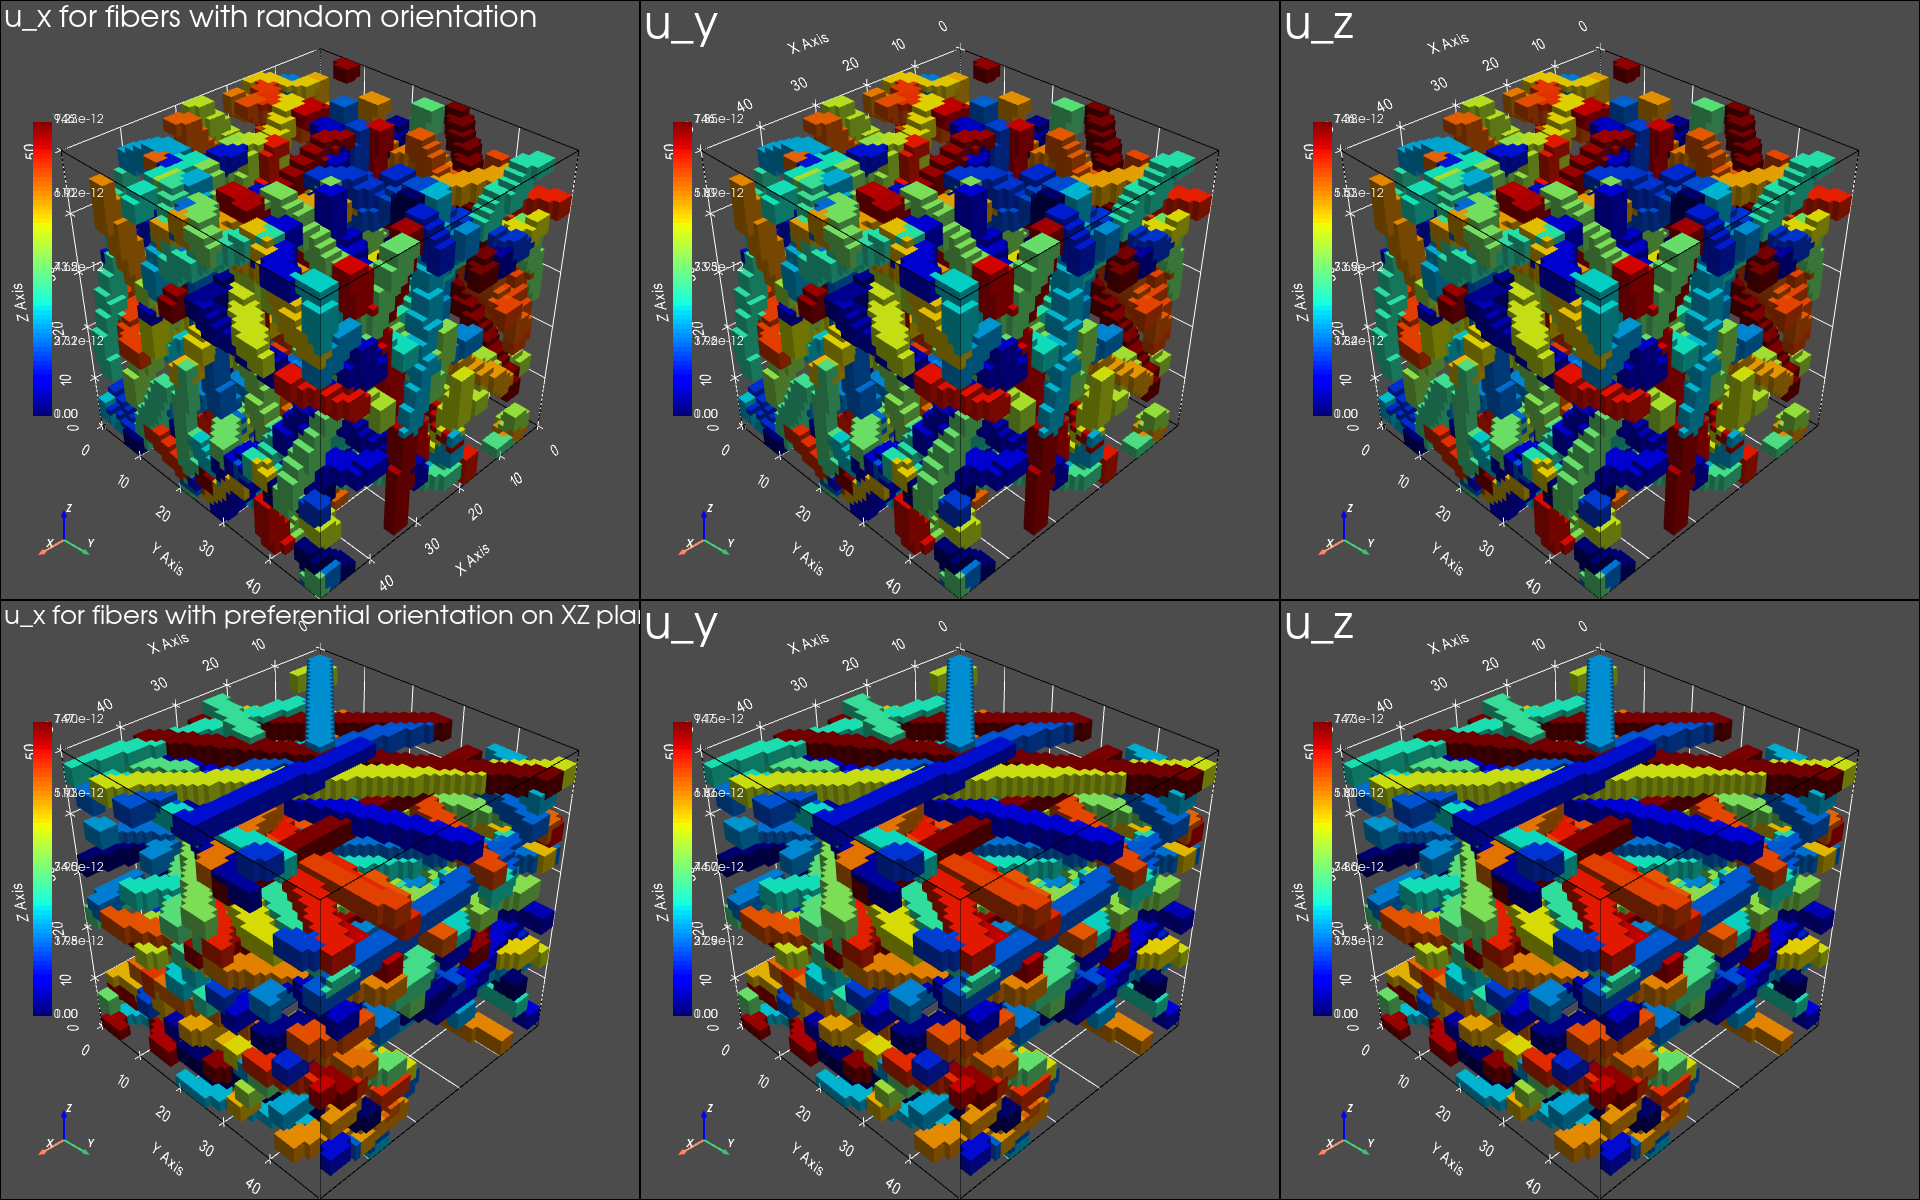

In [14]:
# usually pyvista plots are interactive, but this multi-plot is too heavy
pv.set_jupyter_backend('static')

p = pv.Plotter(shape=(2, 3), off_screen=True)
ws1.voxel_length = 1  # the voxel_length is converted to 1 for plotting the workspace together with the velocity
ws2.voxel_length = 1
p.subplot(0, 0)
p.add_text("u_x for fibers with random orientation")
puma.render_orientation(u_x1, add_to_plot=p, scale_factor=1e8, plot_directly=False)
puma.render_volume(ws1, cutoff=(1, ws1.max()), cmap='jet', add_to_plot=p, plot_directly=False, notebook=True)
p.subplot(0, 1)
p.add_text("u_y")
puma.render_orientation(u_y1, add_to_plot=p, scale_factor=1e8, plot_directly=False)
puma.render_volume(ws1, cutoff=(1, ws1.max()), cmap='jet', add_to_plot=p, plot_directly=False, notebook=True)
p.subplot(0, 2)
p.add_text("u_z")
puma.render_orientation(u_z1, add_to_plot=p, scale_factor=1e8, plot_directly=False)
puma.render_volume(ws1, cutoff=(1, ws1.max()), cmap='jet', add_to_plot=p, plot_directly=False, notebook=True)
p.subplot(1, 0)
p.add_text("u_x for fibers with preferential orientation on XZ plane")
puma.render_orientation(u_x2, add_to_plot=p, scale_factor=1e8, plot_directly=False)
puma.render_volume(ws2, cutoff=(1, ws2.max()), cmap='jet', add_to_plot=p, plot_directly=False, notebook=True)
p.subplot(1, 1)
p.add_text("u_y")
puma.render_orientation(u_y2, add_to_plot=p, scale_factor=1e8, plot_directly=False)
puma.render_volume(ws2, cutoff=(1, ws2.max()), cmap='jet', add_to_plot=p, plot_directly=False, notebook=True)
p.subplot(1, 2)
p.add_text("u_z")
puma.render_orientation(u_z2, add_to_plot=p, scale_factor=1e8, plot_directly=False)
puma.render_volume(ws2, cutoff=(1, ws2.max()), cmap='jet', add_to_plot=p, plot_directly=False, notebook=True)
p.show()

pv.set_jupyter_backend('ipyvtklink')  # to set pyvista plots back to interactive

## Tutorial: Segmentation

In this tutorial we introduce pumapy's segmentation capabilities. 

### Porespace identification

When dealing with porous materials, it is often useful to distinguish between closed and open porosity. This is particularly relevant when particle or ray casting simulations need to be performed. In these cases, closed porosity throughout a domain becomes a problem, because particles get trapped inside these pockets, inevitably altering the output of a simulation. For this reason, a method to identify and fill the closed porosity was implemented in both C++ PuMA and pumapy.
Let's first create a 50% dense sample full of hollowed out spheres and visualize it:

In [ ]:
ws = puma.generate_random_spheres((200, 200, 200), diameter=20, porosity=0.5, allow_intersect=True, segmented=False)

# void is 0, solid is 255, but the material does not jump from 0-255, it gradually does so
# we therefore use this gradient to select the shell of each sphere
ws.binarize_range((1, 254))

puma.render_volume(ws, cutoff=(1, 1), solid_color=(1,1,1), notebook=True)

Now we can run the pore filling algorithm, which runs a connected component analysis. The fill_closed_pores function needs to be given the solid range (in this case only 1 since we have already binarized the workspace) and the ID value to fill the closed porosity throughout the workspace (in this case we set 2).

In [ ]:
filled_ws, pores = puma.fill_closed_pores(ws, (1, 1), 2, return_pores=True)

When the return_pores flag is True, then it returns both the already filled workspace and a Numpy array of pores with IDs: solid == 0, largest pore (likely open porosity) == 1, smaller pores (likely closed porosity) == 2 - N. We can visualize both these outputs as:

In [ ]:
puma.render_volume(pores[:pores.shape[0]//2], cutoff=(1, 10), solid_color=None, notebook=True, cmap='jet')

In [ ]:
puma.render_volume(filled_ws, notebook=True, cmap='jet')

Note that the identify_porespace function performs the same operation as the fill_closed_pores, except that it does not fill the closed pores throughout the workspace, it only returns the labelled pores identified. 

# C++ examples

In order to run this tutorial on Colab, make sure to setup the environment correctly, as explained in the "Installation setup and imports" section.

In this section we outline the examples related to the PuMA C++ library. In order to run them, we need to first create a couple of files necessary to compile and run our C++ code, namely CMakeLists.txt and MakeAll.sh. We then create a function that automatically calls them.

In [ ]:
CMakeLists_txt = """
cmake_minimum_required(VERSION 3.0)
set(CMAKE_CXX_STANDARD 14)

project(example)

set(CMAKE_INSTALL_RPATH "${CMAKE_INSTALL_PREFIX}/lib")
set(CMAKE_INSTALL_RPATH_USE_LINK_PATH TRUE)
set(CMAKE_MACOSX_RPATH TRUE)

if(APPLE)
    set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} -Xpreprocessor -fopenmp --std=c++0x -Wno-format -Wno-literal-conversion -Wno-deprecated-register -Wno-return-type")
elseif(UNIX)
    set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} -fopenmp --std=c++0x")
endif()

include_directories(${CONDA_PREFIX}/include)
include_directories(${CONDA_PREFIX}/include/eigen3/Eigen)

SET(DEP_LIBS "-ldl -L${CONDA_PREFIX}/lib -lPuMA -ltiff -lfftw3_threads -lfftw3")
if(APPLE)
    SET(DEP_LIBS "${DEP_LIBS} -lomp")
endif()

add_executable(example example.cpp)
target_link_libraries(example ${DEP_LIBS})
install(TARGETS example DESTINATION ${CMAKE_INSTALL_PREFIX}/bin)
"""
if not os.path.exists('out'):
    os.makedirs('out')
with open('out/CMakeLists.txt', 'w') as file:
    file.write(CMakeLists_txt)


makeAll_sh = """
cd "${0%/*}" || exit 1    # Run from this directory
set -e  # exit when any command fails
"""
if not ('google.colab' in str(get_ipython())):
    makeAll_sh += """
    eval "$(conda shell.bash hook)"  # this is required for conda
    conda activate puma
    """
makeAll_sh += """
mkdir -p build
cd build
cmake -D CONDA_PREFIX=$CONDA_PREFIX -D CMAKE_INSTALL_PREFIX=$CONDA_PREFIX ..
make -j
make install
"""
with open('out/makeAll.sh', 'w') as file:
    file.write(makeAll_sh)
!chmod +x out/makeAll.sh    


def write_compile_run_example(puma_commands):
    
    with open('out/example.cpp', 'w') as file:
        file.write('''
#include <iostream>
#include "puma.h"
using namespace std;
int main (int argc, char **argv){''' + puma_commands + "return 0;\n}\n")
    
    !./out/makeAll.sh && example

For your reference, you can now check out the two files that have been created, as well as the example.cpp that gets written every time we run one of the examples below.

## Example: Primitives

In [ ]:
write_compile_run_example('''

// primitives: Matrix
cout << endl << "Creating a matrix with user input size and printing a slice of it:"<< endl;

puma::Matrix<double> mat(10,10,10, 3.5); // sets all the elements to 3.5
// N.B. note that if a value is not specified, matrix just allocates the memory, does not set the matrix to zeros

mat.set(0,-1, 4,4, 4,4, 1); // creating a central solid fiber
// N.B. -1 specifies until the end of domain mat.X()-1

mat.printRange(0,-1, 0,-1, 4,5);

''')

In [ ]:
write_compile_run_example('''

// primitives: Workspace
cout << endl << "Creating a grayscale workspace:"<< endl;

puma::Workspace grayWS(10,10,10,1e-6, false); // automatically initializes it to zeros
// false prevents it from writing the log, unnecessary for these tutorials

grayWS.matrix.set(0,-1, 4,4, 4,4, 255); // creating a central solid fiber

grayWS.matrix.printRange(0,-1, 0,-1, 4,5);


cout << endl << "Segmenting it into a segmented workspace:"<< endl;

puma::Cutoff cutoff(0,89); // calling puma::Cutoff is equivalent to calling pair<int,int>
grayWS.setMaterialID(cutoff,0);   // mask the segmented ws with the grayscale one, thresholding by assigning 0 to the range 0-89

grayWS.setMaterialID(puma::Cutoff(90,255),1); // assigning 1 to the range 90-255, with the direct cutoff pair

grayWS.matrix.printRange(0,-1, 0,-1, 4,5);

''')

In [ ]:
write_compile_run_example('''

// primitives: Vec3
cout << endl << "Creating a vector with three components:"<< endl;

puma::Vec3<double> vector(60,5,1);
vector.x = 1; // reassign one of the components

cout << "Computing magnitude of original vector: " << vector.magnitude() << endl; // compute the magnitude
cout << "Computing magnitude of normalized vector: " << (vector.norm()).magnitude() << endl; // compute the magnitude

puma::Vec3<double> vector2(50,0,0);
vector.dot(vector2);   // dot product
vector.cross(vector2); // cross product

''')

In [ ]:
write_compile_run_example('''

// primitives: Vec4
cout << endl << "Creating a vector with three components and a time value" << endl;

puma::Vec4<float> vec1(1.2, -3.4, 5.6);
puma::Vec4<float> vec2(1.2, -3.4, 5.6, 1);

''')

In [ ]:
write_compile_run_example('''

// primitives: MatVec3
cout << endl << "Creating a direction matrix for a single fiber running along x:" << endl;

puma::MatVec3<double> directions(10,10,10); // initializes it to Vec3(0,0,0)
directions.set(0,-1, 4,4, 4,4, puma::Vec3<double>(1,0,0));

directions.printRange(0,-1, 0,-1, 4,5);

''')

## Example: import/export

In [ ]:
write_compile_run_example('''

// export3dtiff
cout << endl << "Exporting a puma matrix to a tiff file:"<< endl;

puma::Matrix<int> mat(10,10,10, 0);
mat.set(0,-1, 4,4, 4,4, 150); // -1 specifies until the end of domain

puma::export_3DTiff(&mat, "out/matrix_example_notnorm", false); // not normalized
puma::export_3DTiff(&mat, "out/matrix_example_norm", true); // normalized --> 150 becomes 255 since highest value


cout<< endl << "Exporting a workspace to a tiff file:"<< endl;

puma::Workspace grayWS(10,10,10,1e-6, false);
grayWS.matrix.set(0,-1, 4,4, 4,4, 255);

puma::export_3DTiff(&grayWS, "out/workspace_example_notnorm", false);

''')

In [ ]:
write_compile_run_example('''

// exportbin
cout << endl << "Exporting a puma matrix to a binary file:"<< endl;

puma::Matrix<int> mat(10,10,10, 0);
mat.set(0,-1, 4,4, 4,4, 150); // -1 specifies until the end of domain

puma::export_bin(&mat, "out/mat_example"); // to specify numThreads, add one more int to the inputs at the end


cout<< endl << "Exporting a workspace to a binary file:"<< endl;

puma::Workspace grayWS(10,10,10,1e-6, false);
grayWS.matrix.set(0,-1, 4,4, 4,4, 255);

puma::export_bin(&grayWS, "out/workspace_example");

''')

In [ ]:
write_compile_run_example('''

// exportvtk
cout << endl << "Exporting a puma matrix to a vtk file:"<< endl;

puma::Matrix<int> mat(10,10,10, 0);
mat.set(0,-1, 4,4, 4,4, 150); // -1 specifies until the end of domain

puma::export_vtk(&mat, "out/mat_example"); // to specify numThreads, add one more int to the inputs at the end
puma::export_vtk(&mat, "out/mat_example_ASCII", 'a'); // export vtk it in ASCII instead of BINARY
puma::export_vtk(&mat, "out/mat_example_ASCII_unstructured", 'a', true); // export vtk to an unstructured grid (for import in code Aster)


cout<< endl << "Exporting a workspace to a vtk file:"<< endl;

puma::Workspace grayWS(10,10,10,1e-6, false);
grayWS.matrix.set(0,-1, 4,4, 4,4, 255);

puma::export_vtk(&grayWS, "out/workspace_example");

''')

In [ ]:
write_compile_run_example('''

// exportstl
cout << endl << "Running the Marching Cubes as the previous example and exporting the triangles created to an stl file:"<< endl;

puma::Workspace grayWS(1e-6, false);
puma::import_3DTiff(&grayWS,puma::path_to_example_file("200_fiberform.tif"),0);

// 1. Exporting the STL Directly
puma::export_STL(&grayWS, puma::Cutoff(90,255), false,"out/triangles1");

// 2. Computing the Triangles separately via the marching cubes algorithm, then exporting the STL
vector< puma::Triangle<float> > tris;
puma::isosurface_MarchingCubes(&tris, &grayWS, puma::Cutoff(90,255), true,1,false,0);
cout << endl << "Number of triangles generated: " << tris.size()<< endl;
puma::export_STL(&tris,false,"out/triangles2");

// 3. Segmenting the Workspace, then computing the Triangles separately via the marching cubes algorithm, then exporting the STL
grayWS.setMaterialID(puma::Cutoff(0,89),0);
grayWS.setMaterialID(puma::Cutoff(90,255),1);
puma::isosurface_MarchingCubes(&tris, &grayWS, puma::Cutoff(1,1), true,1,false,0);
cout << endl << "Number of triangles generated: " << tris.size()<< endl;
puma::export_STL(&tris,false,"out/triangles3");

''')

In [ ]:
write_compile_run_example('''

// exporttextfile
cout << endl << "Exporting a puma matrix to a text file:"<< endl;

puma::Matrix<int> mat(10,10,10, 0);
mat.set(0,-1, 4,4, 4,4, 150); // -1 specifies until the end of domain

puma::export_Textfile(&mat, "out/mat_example"); // to specify numThreads, add one more int to the inputs at the end


cout<< endl << "Exporting a workspace to a text file:"<< endl;

puma::Workspace grayWS(10,10,10,1e-6, false);
grayWS.matrix.set(0,-1, 4,4, 4,4, 255);

puma::export_Textfile(&grayWS, "out/workspace_example");

''')

In [ ]:
write_compile_run_example('''

// import3dtiff
cout << endl << "Importing a grayscale workspace of FiberForm and printing a subset of it:" << endl;

puma::Workspace grayWS(1e-6, false); // no need to specify the size since the import function takes care of it
puma::import_3DTiff(&grayWS, puma::path_to_example_file("200_fiberform.tif"),0); // note that .tif is required

grayWS.matrix.printRange(150,(int)grayWS.X()-1, 150, (int)grayWS.Y()-1, 100,101);


cout << "Importing the same segmented workspace and printing the same subset of it:" << endl;

puma::Workspace segWS(1e-6, false); // no need to specify the size since the import function takes care of it
puma::import_3DTiff(&segWS, puma::path_to_example_file("200_fiberform_segmented.tif"), 0);

segWS.matrix.printRange(150,(int)segWS.X()-1, 150, (int)segWS.Y()-1, 100,101);

''')

In [ ]:
write_compile_run_example('''

// importbin
cout << endl << "Importing a puma matrix to a binary file:"<< endl;

// *** Note: Run first ExportBin_Example to generate the data imported in this example ***

puma::Matrix<int> mat(10,10,10, 0);
mat.set(0,-1, 4,4, 4,4, 150); // -1 specifies until the end of domain

puma::import_bin(&mat, "out/mat_example.puma"); // note that .puma is required
// to specify the number of processors used to read file (i.e. numThreads), add one more int to the inputs at the end

mat.printRange(0,-1, 0,-1, 4,5);


cout<< endl << "Importing a workspace to a binary file:"<< endl;

puma::Workspace grayWS(10,10,10,1e-6, false);
grayWS.matrix.set(0,-1, 4,4, 4,4, 255);

puma::import_bin(&grayWS, "out/workspace_example.puma");

grayWS.matrix.printRange(0,-1, 0,-1, 4,5);

''')

## Example: volume fraction, isosurface and surface area

In [ ]:
write_compile_run_example('''

// volumefraction
cout << endl << "Computing Porosity and Volume Fraction of a segmented Fiberform sample:"<< endl;

puma::Workspace workspace(1.3, false);
puma::import_3DTiff(&workspace, puma::path_to_example_file("200_fiberform_segmented.tif"),0);

cout << endl << "Porosity: " << puma::compute_VolumeFraction(&workspace,0,0) << endl;
cout << "Fiber Volume Fraction: " << puma::compute_VolumeFraction(&workspace,1,0) << endl;

''')

In [ ]:
write_compile_run_example('''

// isosurface
cout << endl << "Running the Marching Cubes on a grayscale FiberForm sample, with closed edges and factor of 2:"<< endl;

puma::Workspace grayWS(1e-6, false);
puma::import_3DTiff(&grayWS,puma::path_to_example_file("200_fiberform.tif"),0);

// 1. Computing the Triangles via the Marching Cubes Algorithm. Faster, but there can be small holes in the mesh. Good for visualizations, bad for simulations
vector< puma::Triangle<float> > tris;
puma::isosurface_MarchingCubes(&tris, &grayWS,puma::Cutoff(90,255), true,1,false,0);
cout << endl << "Number of triangles generated - Maching Cubes Regular: " << tris.size()<< endl;


// 2. Computing the Triangles via the Lewiner Marching Cubes Algorithm. Slower, more triangles, but gaurantees topologically correct surface
puma::isosurface_LewinerMarchingCubes(&tris, &grayWS,puma::Cutoff(90,255), true,1,false,0);
cout << endl << "Number of triangles generated - Maching Cubes Lewiner: " << tris.size()<< endl;


// 3. Segmenting the Workspace, then computing the Triangles separately via the marching cubes algorithm, then exporting the STL
grayWS.setMaterialID(puma::Cutoff(0,89),0);
grayWS.setMaterialID(puma::Cutoff(90,255),1);
puma::isosurface_MarchingCubes(&tris,&grayWS,puma::Cutoff(90,255),true,1,false,0);
cout << endl << "Number of triangles generated - Segmented: " << tris.size()<< endl;

''')

In [ ]:
write_compile_run_example('''

// surfacearea
cout << endl << "Computing the surface area of a sample of FiberForm:"<< endl;

puma::Workspace grayWS(1e-6, false);
puma::import_3DTiff(&grayWS,puma::path_to_example_file("200_fiberform.tif"),0);

pair<double, double> sa = compute_SurfaceAreaMarchingCubes(&grayWS, puma::Cutoff(128, 255), true, 0);

cout << endl << "Raw Surface Area: " << sa.first << " m^2" << endl;
cout << "Specific Surface Area: " << sa.first << " 1/m" << endl;

''')

## Example: image filters

In [ ]:
write_compile_run_example('''

// medianfilter3d
cout << endl << "Applying a Median filter to a FiberForm sample and printing a slice of it:"<< endl;

puma::Workspace grayWS(1e-6, false);

puma::import_3DTiff(&grayWS, puma::path_to_example_file("200_fiberform_segmented.tif"),0);

cout << "Before Median filter:"<< endl;
grayWS.matrix.printRange(50,-1, 50, -1, 50,51);

//in this case, the return should be true since all values are valid
puma::filter_Median3D(&grayWS,3);

cout << endl << "After Median filter:"<< endl;
grayWS.matrix.printRange(50,-1, 50, -1, 50,51);

''')

In [ ]:
write_compile_run_example('''

// meanfilter3d
cout << endl << "Applying a Mean filter to a FiberForm sample and printing a slice of it:"<< endl;

puma::Workspace grayWS(1e-6, false);

puma::import_3DTiff(&grayWS, puma::path_to_example_file("200_fiberform_segmented.tif"),0);

cout << "Before Mean filter:"<< endl;
grayWS.matrix.printRange(50,-1, 50, -1, 50,51);

//in this case, the return should be true since all values are valid
puma::filter_Mean3D(&grayWS,3);

cout << endl << "After Mean filter:"<< endl;
grayWS.matrix.printRange(50,-1, 50, -1, 50,51);

''')

In [ ]:
write_compile_run_example('''

// bilateralfilter 
cout << endl << "Applying a Bilateral filter to a FiberForm sample and printing a slice of it:"<< endl;

puma::Workspace grayWS(1e-6, false);

puma::import_3DTiff(&grayWS, puma::path_to_example_file("200_fiberform_segmented.tif"),0);

cout << "Before Bilateral filter:"<< endl;
grayWS.matrix.printRange(50,-1, 50, -1, 50,51);

//in this case, the return should be true since all values are valid
puma::filter_Bilateral(&grayWS,4,4,50);

cout << endl << "After Bilateral filter:"<< endl;
grayWS.matrix.printRange(50,-1, 50, -1, 50,51);

''')

## Example: generate random fibers

In [ ]:
write_compile_run_example('''

// generaterandomfibers: straightCircle
cout << endl << "Creating a 200^3 domain with non-intersecting random fibers having a circular cross section, slight preference for angle in XY:"<< endl;

// Creates an empty workspace
puma::Workspace grayWS(1e-6, false);

// Preparing inputs for fibers generation
RandomFibersInput input;
input.straightCircle(200,200,200,5,0,200,0,90,90,15,false,0.9,100);
input.print = true; // printing option can be turned off like this, ON as a default

// Generating fibers
puma::generateRandomFibers(&grayWS, input);

// Export to 3D tiff
puma::export_3DTiff(&grayWS,"out/RandomFibers_straightCircle_example.tiff",false);

''')

In [ ]:
write_compile_run_example('''

// generaterandomfibers: curvedCircle
puma::Workspace grayWS(1e-6, false);

RandomFibersInput input;
input.curvedCircle(100,100,100,5,0,50,0,90,90,15,false,0.95,100,150,0,1e-3);

puma::generateRandomFibers(&grayWS, input);


puma::Workspace grayWS2(1e-6, false);

RandomFibersInput input2;
input2.curvedCircle(100,100,100,5,0,50,0,90,90,15,true,0.9,100,150,0,1e-3);

puma::generateRandomFibers(&grayWS2, input2);

''')

In [ ]:
write_compile_run_example('''

// generaterandomfibers: straightFlower
puma::Workspace grayWS(1e-6, false);

RandomFibersInput input;
input.straightFlower(200,200,200,5,0,200,0,90,90,15,false,0.90,100,4,1,5,2,0);

puma::generateRandomFibers(&grayWS, input);


puma::Workspace grayWS2(1e-6, false);

RandomFibersInput input2;
input2.straightFlower(200,200,200,5,0,200,0,90,90,15,true,0.90,100,4,1,5,2,0);

puma::generateRandomFibers(&grayWS2, input2);

''')

In [ ]:
write_compile_run_example('''

// generaterandomfibers: straightFlower_Hollow
puma::Workspace grayWS(1e-6, false);

RandomFibersInput input;
input.straightFlower_Hollow(200,200,200,5,0,200,0,90,90,15,false,0.90,100,4,1,5,2,0,1,2.5,0);

puma::generateRandomFibers(&grayWS, input);


puma::Workspace grayWS2(1e-6, false);

RandomFibersInput input2;
input2.straightFlower_Hollow(200,200,200,5,0,200,0,90,90,15,true,0.90,100,4,1,5,2,0,1,2.5,0);

puma::generateRandomFibers(&grayWS2, input2);

''')

In [ ]:
write_compile_run_example('''

// generaterandomfibers: curvedFlower
puma::Workspace grayWS(1e-6, false);

RandomFibersInput input;
input.curvedFlower(100,100,100,5,0,100,0,90,90,15,false,0.95,100,120,0,1e-3,4,1,5,2,0);

puma::generateRandomFibers(&grayWS, input);


puma::Workspace grayWS2(1e-6, false);

RandomFibersInput input2;
input2.curvedFlower(100,100,100,5,0,100,0,90,90,15,true,0.95,100,120,0,1e-3,4,1,5,2,0);

puma::generateRandomFibers(&grayWS2, input2);

''')

In [ ]:
write_compile_run_example('''

// generaterandomfibers: curvedFlower_Hollow
puma::Workspace grayWS(1e-6, false);

RandomFibersInput input;
input.curvedFlower_Hollow(100,100,100,5,0,100,0,90,90,15,false,0.95,100,120,0,1e-3,4,1,5,2,0,1,2.5,0);

puma::generateRandomFibers(&grayWS, input);


puma::Workspace grayWS2(1e-6, false);

RandomFibersInput input2;
input2.curvedFlower_Hollow(100,100,100,5,0,100,0,90,90,15,true,0.95,100,120,0,1e-3,4,1,5,2,0,1,2.5,0);

puma::generateRandomFibers(&grayWS2, input2);

''')

## Example: generate random spheres

In [ ]:
write_compile_run_example('''

// generaterandomspheres: non-intersecting large spheres
cout << endl << "Creating a 200^3 domain with non-intersecting spheres:"<< endl;

puma::Timer t;

// Creates an empty workspace
puma::Workspace sphereWS(1e-6, false);

// Preparing inputs for spheres generation
RandomSpheresInput input(200,200,200,80.0,3.0,false,0.99,100);

// Generating spheres
puma::generateRandomSpheres(&sphereWS, input);

// Printing the elapsed time
cout << "Time: " << t.elapsed() << endl;

// Export to 3D tiff
puma::export_3DTiff(&sphereWS,"out/Generate_RandomSpheres_nonintersecting",false);

// Creating triangulated isosurface
vector<puma::Triangle<float> > Triangles;
puma::isosurface_MarchingCubes(&Triangles,&sphereWS,puma::Cutoff(128,255),true,1,false,40);

// Exporting to stl file
Export_STL test(&Triangles,false,"out/Generate_RandomSpheres_nonintersecting");

''')

In [ ]:
write_compile_run_example('''

// generaterandomspheres: intersecting large spheres
cout << endl << "Creating a 200^3 domain with intersecting spheres:"<< endl;

puma::Workspace sphereWS(1e-6, false);

RandomSpheresInput input(200,200,200,10.0,3.0,true,0.99,100);
puma::generateRandomSpheres(&sphereWS, input);

puma::export_3DTiff(&sphereWS,"out/Generate_RandomSpheres_intersecting.tif",false);

vector<puma::Triangle<float> > Triangles;
puma::isosurface_MarchingCubes(&Triangles,&sphereWS,puma::Cutoff(128,255),true,1,false);

Export_STL test(&Triangles,false,"out/Generate_RandomSpheres_intersecting.stl");

''')

## Example: generate tpms

In [ ]:
write_compile_run_example('''

double diameter = 20; // in mm
double height = 38.1; // in mm
double p = 4.72;
double q = 0.5045;
bool circle = true;
bool exportSTL = false;
bool binaryTiff = true;
bool continuousTiff = true;
int equationNumber = 0; // equation 0, 1 or 2

std::string outputFolder = "out/";
std::string outputLabel = "equation1";


int scale = 10; // keep between 5-20


int voxelsX = diameter * scale;
int voxelsY = diameter * scale;
int voxelsZ = height * scale;

double radius = diameter * scale / 2.0;
double p_scaled = p / scale;

puma::Workspace ws(1e-6,false);

//  triply periodic minimal surface (TPMS)
TPMSInput input(voxelsX,voxelsY,voxelsZ,p_scaled,p_scaled,q,q, equationNumber);
bool success = puma::generateTPMS(&ws, input);

/// Comment out this section to keep rectangular
if(circle){
    for(int i=0;i<ws.X();i++){
        for(int j=0;j<ws.Y();j++){
            for(int k=0;k<ws.Z();k++){
                if(std::sqrt((i-ws.X()/2.0)*(i-ws.X()/2.0) + (j-ws.Y()/2.0)*(j-ws.Y()/2.0)) > radius ){
                    ws.matrix(i,j,k) = 0;
                }
            }
        }
    }
}

if (success) {
    if(exportSTL){
        puma::export_STL(&ws, puma::Cutoff(128, 255), false, outputFolder + outputLabel +"_tpms_test.stl");
    }
    
    if(continuousTiff) {
        puma::export_3DTiff(&ws, outputFolder + outputLabel + "_tpms_test.tif", false);
    }
    
    if(binaryTiff) {
        ws.setMaterialID(puma::Cutoff(0,127),0);
        ws.setMaterialID(puma::Cutoff(128,255),255);
        puma::export_3DTiff(&ws, outputFolder + outputLabel + "_tpms_test_binary.tif", false);
    }
    
}

''')

## Example: porespace

In [ ]:
write_compile_run_example('''

puma::Workspace grayWS;

RandomFibersInput input;
input.straightFlower_Hollow(200,200,1, 30, 0, 1, 0, 0, 0, 90, true, 0.6, 2, 1, 0, 0, 0, 0, 1, 20, 0);
generateRandomFibers(&grayWS,input);

puma::Matrix<long> poreMatrix;
puma::identifyPoreSpace(&grayWS,&poreMatrix,puma::Cutoff(0,127));

double average =  poreMatrix.average();

cout << "Average porespace: " << average << endl;

''')

In [ ]:
write_compile_run_example('''

puma::Workspace grayWS;

RandomFibersInput input;
input.straightFlower_Hollow(200, 200, 1, 30, 0, 1, 0, 0, 0, 90, true, 0.6, 2, 1, 0, 0, 0, 0, 1, 20, 0);
generateRandomFibers(&grayWS, input);

puma::fillClosedPores(&grayWS, puma::Cutoff(0, 127), 255);

grayWS.setMaterialID(puma::Cutoff(0, 127), 0);
grayWS.setMaterialID(puma::Cutoff(128, 256), 1);

double average = grayWS.matrix.average();

cout << "Average porespace: " << average << endl;

''')

## Example: mean intercept length

In [ ]:
write_compile_run_example('''

cout << endl << "Finding the mean intercept length of a FiberForm 200^3 sample:"<< endl;

// Creating empty workspace
puma::Workspace segWS(1e-6, false);

// Importing FiberForm 200^3 tiff, selecting only subsection of it
puma::import_3DTiff(&segWS,puma::path_to_example_file("200_fiberform_segmented.tif"));

// Computing the Mean Intercept Length
puma::Vec3<double> mil = puma::compute_MeanInterceptLength(&segWS,puma::Cutoff(0,0));

cout << "Mean Intercept Length: " << mil.x << ' ' << mil.y << ' ' << mil.z << endl;

''')

## Example: orientation

In [ ]:
write_compile_run_example('''

// orientation: Ray Casting on Generated Random Fibers

cout << endl << "Creating a random fiber domain and computing the Orientation via the ray casting method:"<< endl;

// Generating random fiber sample (see generateRandomFibers example for step-by-step description)
int scale = 50;
puma::Workspace grayWS(1e-5, false);
puma::MatVec3<double> tangents;
RandomFibersInput input;
input.straightCircle(scale,scale,scale,2,0,scale,0,90,90,90,false,0.9,1);
input.print = false; puma::generateRandomFibers(&grayWS,&tangents,input);

// Segmenting sample
puma::Workspace segWS(grayWS.shape(), false);
segWS.setMaterialID(&grayWS, puma::Cutoff(0,127),0);
segWS.setMaterialID(&grayWS, puma::Cutoff(128,255),1);

// Initializing orientation matrix
puma::MatVec3<double> dirs;

// Computing orientation using Cay Casting (RC)
puma::compute_orientationRC(&segWS, puma::Cutoff(1, 1), 15,5, &dirs, false);

// Initializing orientation error matrix
puma::Matrix<double> error;

// Computing orientation error between the estimated orientation (dirs) and the true orientation (tangents)
pair <double, double> MeanSD = puma::compute_orientationComparison(&segWS, &dirs, &tangents, &error, puma::Cutoff(1,1));

cout << "Mean: " << MeanSD.first << endl;
cout << "Standard Deviation: " << MeanSD.second << endl;

''')

In [ ]:
write_compile_run_example('''

// orientation: Artificial Flux on Generated Random Fibers

cout << endl << "Creating a random fiber domain and computing the Orientation via the artificial flux method:"<< endl;

// Generating random fiber sample (see generateRandomFibers example for step-by-step description)
int scale = 50;
puma::Workspace grayWS(1e-5, false);
puma::MatVec3<double> tangents;
RandomFibersInput input;
input.straightCircle(scale,scale,scale,2,0,scale,0,90,90,90,false,0.9,1);
input.print = false; puma::generateRandomFibers(&grayWS,&tangents,input);

puma::Workspace segWS(grayWS.shape(), false);
segWS.setMaterialID(&grayWS,puma::Cutoff(0,127),0);
segWS.setMaterialID(&grayWS,puma::Cutoff(128,255),1);

puma::MatVec3<double> dirs;

// Computing orientation using Artificial Flux (AF)
puma::compute_orientationAF(&segWS, &dirs, puma::Cutoff(1, 1), 1e-5, 10000,false);

puma::Matrix<double> error;
pair <double, double> MeanSD = puma::compute_orientationComparison(&segWS, &dirs, &tangents, &error, puma::Cutoff(1,1));

cout << "Mean: " << MeanSD.first << endl;
cout << "Standard Deviation: " << MeanSD.second << endl;

''')

In [ ]:
write_compile_run_example('''

// orientation: Structure Tensor on Generated Random Fibers

cout << endl << "Creating a random fiber domain and computing the Orientation via the structure tensor method:"<< endl;

// Generating random fiber sample (see generateRandomFibers example for step-by-step description)
int scale = 50;
puma::Workspace grayWS(1e-5, false);
puma::MatVec3<double> tangents;
RandomFibersInput input;
input.straightCircle(scale,scale,scale,2,0,scale,0,90,90,90,false,0.9,1);
input.print = false; puma::generateRandomFibers(&grayWS,&tangents,input);

puma::Workspace segWS(grayWS.shape(), false);
segWS.setMaterialID(&grayWS, puma::Cutoff(0,127),0);
segWS.setMaterialID(&grayWS, puma::Cutoff(128,255),1);

puma::MatVec3<double> dirs;

// Computing orientation using Structure Tensor (ST)
puma::compute_orientationST(&segWS, 0.7, 1.1, puma::Cutoff(1, 1), &dirs,false);

puma::Matrix<double> error;
pair <double, double> MeanSD = puma::compute_orientationComparison(&segWS, &dirs, &tangents, &error, puma::Cutoff(1,1));

cout << "Mean: " << MeanSD.first << endl;
cout << "Standard Deviation: " << MeanSD.second << endl;

''')

## Example: conductivity

In [ ]:
write_compile_run_example('''

// fvthermalconductivity: Multiple materials in series
cout << endl << "Computing the thermal conductivity using finite volume considering a locally isotropic sample having several materials in series:"<< endl;

// Initializing Workspace
puma::Workspace segWS(100,57,62,0,1e-6, false);

// Setting the workspace values of the materials in series
segWS.matrix.set(10,19,0,56,0,61,1);
segWS.matrix.set(20,29,0,56,0,61,2);
segWS.matrix.set(30,39,0,56,0,61,3);
segWS.matrix.set(40,49,0,56,0,61,4);
segWS.matrix.set(50,59,0,56,0,61,5);
segWS.matrix.set(60,69,0,56,0,61,6);
segWS.matrix.set(70,79,0,56,0,61,7);
segWS.matrix.set(80,89,0,56,0,61,8);
segWS.matrix.set(90,99,0,56,0,61,9);

// Initializing Temperature field
puma::Matrix<double> T;

// Initializing material conductivity
map<int, double> matCond;
matCond[0] = 1;
matCond[1] = 2;
matCond[2] = 3;
matCond[3] = 4;
matCond[4] = 5;
matCond[5] = 6;
matCond[6] = 7;
matCond[7] = 8;
matCond[8] = 9;
matCond[9] = 10;

// Running simulation
puma::Vec3<double> k = puma::compute_FVThermalConductivity(&segWS, &T, matCond,"periodic","bicgstab",'z',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << k.x << " kxy " << k.y << " kxz " << k.z << endl;

''')

In [ ]:
write_compile_run_example('''

// fvthermalconductivity: FiberForm 100^3
cout << endl << "Computing the thermal conductivity using finite volume considering a locally isotropic FiberForm 100^3 sample:"<< endl;

// Initializing Workspace
puma::Workspace ws(1e-6, false);

// Importing 3D tiff
puma::import_3DTiff(&ws,puma::path_to_example_file("100_fiberform.tif"));

// Segmenting workspace by thresholding
ws.setMaterialID(&ws,puma::Cutoff(0,89),0);
ws.setMaterialID(&ws,puma::Cutoff(90,255),1);

// Initializing Temperature field and material conductivity
puma::Matrix<double> T;
map<int, double> matCond;
matCond[0] = 0.0257; // air conductivity
matCond[1] = 12; // approximation to fiber conductivity

// Running simulation in three directions
puma::Vec3<double> kx = puma::compute_FVThermalConductivity(&ws, &T, matCond,"symmetric","cg",'x',1e-3,10000,true);
puma::Vec3<double> ky = puma::compute_FVThermalConductivity(&ws, &T, matCond,"symmetric","cg",'y',1e-3,10000,true);
puma::Vec3<double> kz = puma::compute_FVThermalConductivity(&ws, &T, matCond,"symmetric","cg",'z',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << kx.x << " kxy " << kx.y << " kxz " << kx.z << endl;
cout << "kyx " << ky.x << " kyy " << ky.y << " kyz " << ky.z << endl;
cout << "kzx " << kz.x << " kzy " << kz.y << " kzz " << kz.z << endl;

''')

In [ ]:
write_compile_run_example('''

// ejthermalconductivity: Multiple materials in series
cout << endl << "Computing the thermal conductivity using explicit jump considering a locally isotropic sample having several materials in series:"<< endl;

// Initializing Workspace
puma::Workspace segWS(100,57,62,0,1e-6, false);

// Setting the workspace values of the materials in series
segWS.matrix.set(10,19,0,56,0,61,1);
segWS.matrix.set(20,29,0,56,0,61,2);
segWS.matrix.set(30,39,0,56,0,61,3);
segWS.matrix.set(40,49,0,56,0,61,4);
segWS.matrix.set(50,59,0,56,0,61,5);
segWS.matrix.set(60,69,0,56,0,61,6);
segWS.matrix.set(70,79,0,56,0,61,7);
segWS.matrix.set(80,89,0,56,0,61,8);
segWS.matrix.set(90,99,0,56,0,61,9);

// Initializing Temperature field
puma::Matrix<double> T;

// Initializing material conductivity
map<int, double> matCond;
matCond[0] = 1;
matCond[1] = 2;
matCond[2] = 3;
matCond[3] = 4;
matCond[4] = 5;
matCond[5] = 6;
matCond[6] = 7;
matCond[7] = 8;
matCond[8] = 9;
matCond[9] = 10;

// Running simulation
puma::Vec3<double> k = compute_EJThermalConductivity(&segWS, &T, matCond,'x',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << k.x << " kxy " << k.y << " kxz " << k.z << endl;

''')

In [ ]:
write_compile_run_example('''

// ejthermalconductivity: FiberForm 100^3
cout << endl << "Computing the thermal conductivity using explicit jump considering a locally isotropic FiberForm 100^3 sample:"<< endl;

// Initializing Workspace
puma::Workspace ws(1e-6, false);

// Importing 3D tiff
puma::import_3DTiff(&ws,puma::path_to_example_file("100_fiberform.tif"));

// Segmenting workspace by thresholding
ws.setMaterialID(&ws,puma::Cutoff(0,89),0);
ws.setMaterialID(&ws,puma::Cutoff(90,255),1);

// Initializing Temperature field and material conductivity
puma::Matrix<double> T;
map<int, double> matCond;
matCond[0] = 0.0257; // air conductivity
matCond[1] = 12; // approximation to fiber conductivity

// Running simulation in three directions
puma::Vec3<double> kx = compute_EJThermalConductivity(&ws, &T, matCond,'x',1e-3,10000,true);
puma::Vec3<double> ky = compute_EJThermalConductivity(&ws, &T, matCond,'y',1e-3,10000,true);
puma::Vec3<double> kz = compute_EJThermalConductivity(&ws, &T, matCond,'z',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << kx.x << " kxy " << kx.y << " kxz " << kx.z << endl;
cout << "kyx " << ky.x << " kyy " << ky.y << " kyz " << ky.z << endl;
cout << "kzx " << kz.x << " kzy " << kz.y << " kzz " << kz.z << endl;

''')

In [ ]:
write_compile_run_example('''

// fvanisotropicthermalconductivity: Multiple materials in series
cout << endl << "Computing the thermal conductivity using finite volume considering a locally anisotropic sample having several materials in series:"<< endl;

// Initializing Workspace
puma::Workspace segWS(100,57,62,0,1e-6, false);

// Setting the workspace values of the materials in series
segWS.matrix.set(10,19,0,56,0,61,1);
segWS.matrix.set(20,29,0,56,0,61,2);
segWS.matrix.set(30,39,0,56,0,61,3);
segWS.matrix.set(40,49,0,56,0,61,4);
segWS.matrix.set(50,59,0,56,0,61,5);
segWS.matrix.set(60,69,0,56,0,61,6);
segWS.matrix.set(70,79,0,56,0,61,7);
segWS.matrix.set(80,89,0,56,0,61,8);
segWS.matrix.set(90,99,0,56,0,61,9);

// Initializing Temperature and Flux field
puma::Matrix<double> T;
puma::MatVec3<double> q;

// Initializing material conductivity
map<int, vector<double>> matCond;
matCond[0] = {1,1,1,0,0,0};
matCond[1] = {2,2,2,0,0,0};
matCond[2] = {3,3,3,0,0,0};
matCond[3] = {4,4,4,0,0,0};
matCond[4] = {5,5,5,0,0,0};
matCond[5] = {6,6,6,0,0,0};
matCond[6] = {7,7,7,0,0,0};
matCond[7] = {8,8,8,0,0,0};
matCond[8] = {9,9,9,0,0,0};
matCond[9] = {10,10,10,0,0,0};

// Running simulation
puma::Vec3<double> k = puma::compute_FVanisotropicThermalConductivity(&segWS, &T, &q, matCond, "mpfa", "symmetric","bicgstab",'x',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << k.x << " kxy " << k.y << " kxz " << k.z << endl;

''')

In [ ]:
write_compile_run_example('''

// fvanisotropicthermalconductivity: FiberForm 100^3
cout << endl << "Computing the thermal conductivity using finite volume considering a locally anisotropic FiberForm 100^3 sample:"<< endl;

// Initializing Workspace
puma::Workspace ws(1e-6, false);

// Importing 3D tiff
puma::import_3DTiff(&ws,puma::path_to_example_file("100_fiberform.tif"));

// Computing orientations using Structure Tensor (ST) method
puma::MatVec3< double> tangents;
puma::compute_orientationST(&ws, 0.7, 0.7, puma::Cutoff(89,255), &tangents);

// Initializing Temperature, flux field and material conductivity
puma::Matrix<double> T;
puma::MatVec3<double> q;
map<int, vector<double>> matCond;
matCond[89] = {0.0257}; // air conductivity
matCond[255] = {15, 8}; // approximation to fiber conductivity, here considered isotropic as an example

// Running simulation in three directions
puma::Vec3<double> kx = puma::compute_FVanisotropicThermalConductivity(&ws, &T, &q, matCond, &tangents, "mpfa", "symmetric","bicgstab",'x',0.1,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << kx.x << " kxy " << kx.y << " kxz " << kx.z << endl;

''')

In [ ]:
write_compile_run_example('''

// fvanisotropicthermalconductivity: homogeneous analytical solution
cout << endl << "Computing the thermal conductivity of an anisotropic slab with a prescribed boundary temperature:"<< endl;

// Domain size
int X = 22, Y = 102, Z = 3;

// Initializing datastructures
puma::Workspace segWS(X, Y, Z, 0, 1e-6, false);
puma::Matrix<double> T;
puma::MatVec3<double> q;
std::map<int, std::vector<double>> matCond;

// Assigning conductivity
matCond[0] = {1, 1, 1, 0.75, 0.75, 0.75}; // kxx,kyy,kzz,kxy,kxz,kyz

// Initialize prescribed boundary temperature
puma::Matrix<double> prescribedBC(2, Y, Z, 0);

// Assigning point temperature in the middle of the top surface
for (int k = 0; k < Z; k++) {
    for (int j = Y/2-1; j < Y/2+1; j++) {
        prescribedBC.at(0, j, k) = 1;
    }
}

// Running anisotropic conductivity solver
puma::Vec3<double> kx = compute_FVanisotropicThermalConductivity(&segWS, &T, &q, matCond, "empfa", "symmetric", &prescribedBC,"bicgstab", 'x', 1e-8, 10000, false);

// Printing slice of the temperature field
T.printSlice('z', 2, 12);

''')

In [ ]:
write_compile_run_example('''

// fvelectricalconductivity: Multiple materials in series
cout << endl << "Computing the electrical conductivity using finite volume considering a locally isotropic sample having several materials in series:"<< endl;

// Initializing Workspace
puma::Workspace segWS(100,57,62,0,1e-6, false);

// Setting the workspace values of the materials in series
segWS.matrix.set(10,19,0,56,0,61,1);
segWS.matrix.set(20,29,0,56,0,61,2);
segWS.matrix.set(30,39,0,56,0,61,3);
segWS.matrix.set(40,49,0,56,0,61,4);
segWS.matrix.set(50,59,0,56,0,61,5);
segWS.matrix.set(60,69,0,56,0,61,6);
segWS.matrix.set(70,79,0,56,0,61,7);
segWS.matrix.set(80,89,0,56,0,61,8);
segWS.matrix.set(90,99,0,56,0,61,9);

// Initializing Temperature field
puma::Matrix<double> T;

// Initializing material conductivity
map<int, double> matCond;
matCond[0] = 1;
matCond[1] = 2;
matCond[2] = 3;
matCond[3] = 4;
matCond[4] = 5;
matCond[5] = 6;
matCond[6] = 7;
matCond[7] = 8;
matCond[8] = 9;
matCond[9] = 10;

// Running simulation
puma::Vec3<double> k = puma::compute_FVElectricalConductivity(&segWS, &T, matCond,"periodic","bicgstab",'z',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << k.x << " kxy " << k.y << " kxz " << k.z << endl;

''')

In [ ]:
write_compile_run_example('''

// fvelectricalconductivity: FiberForm 100^3
cout << endl << "Computing the electrical conductivity using finite volume considering a locally isotropic FiberForm 100^3 sample:"<< endl;

// Initializing Workspace
puma::Workspace ws(1e-6, false);

// Importing 3D tiff
puma::import_3DTiff(&ws,puma::path_to_example_file("200_fiberform_segmented.tif"));

// Segmenting workspace by thresholding
ws.setMaterialID(&ws,puma::Cutoff(0,89),0);
ws.setMaterialID(&ws,puma::Cutoff(90,255),1);

// Initializing Temperature field and material conductivity
puma::Matrix<double> T;
map<int, double> matCond;
matCond[0] = 0.0257; // air conductivity
matCond[1] = 12; // approximation to fiber conductivity

// Running simulation in three directions
puma::Vec3<double> kx = puma::compute_FVElectricalConductivity(&ws, &T, matCond,"symmetric","cg",'x',1e-3,10000,true);
puma::Vec3<double> ky = puma::compute_FVElectricalConductivity(&ws, &T, matCond,"symmetric","cg",'y',1e-3,10000,true);
puma::Vec3<double> kz = puma::compute_FVElectricalConductivity(&ws, &T, matCond,"symmetric","cg",'z',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << kx.x << " kxy " << kx.y << " kxz " << kx.z << endl;
cout << "kyx " << ky.x << " kyy " << ky.y << " kyz " << ky.z << endl;
cout << "kzx " << kz.x << " kzy " << kz.y << " kzz " << kz.z << endl;

''')

In [ ]:
write_compile_run_example('''

// ejelectricalconductivity: Multiple materials in series
cout << endl << "Computing the electrical conductivity using explicit jump considering a locally isotropic sample having several materials in series:"<< endl;

// Initializing Workspace
puma::Workspace segWS(100,57,62,0,1e-6, false);

// Setting the workspace values of the materials in series
segWS.matrix.set(10,19,0,56,0,61,1);
segWS.matrix.set(20,29,0,56,0,61,2);
segWS.matrix.set(30,39,0,56,0,61,3);
segWS.matrix.set(40,49,0,56,0,61,4);
segWS.matrix.set(50,59,0,56,0,61,5);
segWS.matrix.set(60,69,0,56,0,61,6);
segWS.matrix.set(70,79,0,56,0,61,7);
segWS.matrix.set(80,89,0,56,0,61,8);
segWS.matrix.set(90,99,0,56,0,61,9);

// Initializing Temperature field
puma::Matrix<double> T;

// Initializing material conductivity
map<int, double> matCond;
matCond[0] = 1;
matCond[1] = 2;
matCond[2] = 3;
matCond[3] = 4;
matCond[4] = 5;
matCond[5] = 6;
matCond[6] = 7;
matCond[7] = 8;
matCond[8] = 9;
matCond[9] = 10;

// Running simulation
puma::Vec3<double> k = compute_EJElectricalConductivity(&segWS, &T, matCond,'x',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << k.x << " kxy " << k.y << " kxz " << k.z << endl;

''')

In [ ]:
write_compile_run_example('''

// ejelectricalconductivity: FiberForm 100^3
cout << endl << "Computing the electrical conductivity using explicit jump considering a locally isotropic FiberForm 100^3 sample:"<< endl;

// Initializing Workspace
puma::Workspace ws(1e-6, false);

// Importing 3D tiff
puma::import_3DTiff(&ws,puma::path_to_example_file("200_fiberform_segmented.tif"));

// Segmenting workspace by thresholding
ws.setMaterialID(&ws,puma::Cutoff(0,89),0);
ws.setMaterialID(&ws,puma::Cutoff(90,255),1);

// Initializing Temperature field and material conductivity
puma::Matrix<double> T;
map<int, double> matCond;
matCond[0] = 0.0257; // air conductivity
matCond[1] = 12; // approximation to fiber conductivity

// Running simulation in three directions
puma::Vec3<double> kx = compute_EJElectricalConductivity(&ws, &T, matCond,'x',1e-3,10000,true);
puma::Vec3<double> ky = compute_EJElectricalConductivity(&ws, &T, matCond,'y',1e-3,10000,true);
puma::Vec3<double> kz = compute_EJElectricalConductivity(&ws, &T, matCond,'z',1e-3,10000,true);

cout << endl << "Conductivity: " << endl;
cout << "kxx " << kx.x << " kxy " << kx.y << " kxz " << kx.z << endl;
cout << "kyx " << ky.x << " kyy " << ky.y << " kyz " << ky.z << endl;
cout << "kzx " << kz.x << " kzy " << kz.y << " kzz " << kz.z << endl;

''')

## Example: tortuosity

In [ ]:
write_compile_run_example('''

// tortuosity: compute_EJTortuosity
RandomFibersInput input;
input.straightCircle(200,200,200,5,0,200,0,90,90,90,true,0.6,1);

puma::Workspace grayWS;
generateRandomFibers(&grayWS,input);

puma::Matrix<double> C;
puma::Vec3<double> t = compute_EJTortuosity(&grayWS, &C, puma::Cutoff(0,127), 'x', 1e-3, 10000, true, 0);

cout << "tx: " << t.x << ' ' << t.y << ' ' << t.z << endl;

''')

In [ ]:
write_compile_run_example('''

// tortuosity: compute_FVTortuosity
RandomFibersInput input;
input.straightCircle(200,200,200,5,0,200,0,90,90,90,true,0.6,1);

puma::Workspace grayWS;
generateRandomFibers(&grayWS,input);

puma::Matrix<double> C;
puma::Vec3<double> t = compute_FVTortuosity(&grayWS, &C, puma::Cutoff(0,127), "symmetric", "bicgstab", 'x', 1e-3, 10000, true, 0);

cout << "tx: " << t.x << ' ' << t.y << ' ' << t.z << endl;

''')

In [ ]:
write_compile_run_example('''

// tortuosity: compute_particle_cuberille_Tortuosity
RandomFibersInput input;
input.straightCircle(200,200,200,5,0,200,0,90,90,90,true,0.6,1);

puma::Workspace grayWS;
generateRandomFibers(&grayWS,input);

puma::TortuosityReturn tortReturn = compute_particle_cuberille_Tortuosity(&grayWS,puma::Cutoff(0,127),20000,20000,500,1,10000,0);

cout << "Tortuosity: " << tortReturn.tortuosity.toString() << endl;
cout << "Mean Intercept Length: " << tortReturn.meanInterceptLength << endl;
cout << "Diffusion Coefficient: " << tortReturn.diffusionCoefficient.toString() << endl;

''')

In [ ]:
write_compile_run_example('''

// tortuosity: compute_particle_isosurface_Tortuosity
char dir = 'x';

RandomFibersInput input;
input.straightCircle(200,200,200,5,0,200,0,90,90,90,true,0.6,1);

puma::Workspace grayWS;
generateRandomFibers(&grayWS,input);

puma::TortuosityReturn tortReturn = compute_particle_isosurface_Tortuosity(&grayWS,puma::Cutoff(0,127),20000,20000,500,1,10000,0);

cout << "Tortuosity: " << tortReturn.tortuosity.toString() << endl;
cout << "Mean Intercept Length: " << tortReturn.meanInterceptLength << endl;
cout << "Diffusion Coefficient: " << tortReturn.diffusionCoefficient.toString() << endl;

''')